# Projet Ingénieurie des données

Importation des bibliothèques

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV



## Création du jeu de données principal

In [71]:
client_df_brut = pd.read_csv("X.csv", delimiter=",")
batiment_df_brut = pd.read_csv("Y.csv", delimiter=",")
full_df_brut = pd.merge(client_df_brut, batiment_df_brut, on='Identifiant')  

On fusionne les deux dataframes car ils disposent d'un dénominateur commun: l'identifiant du contrat. Les dataframes ont le même nombre de ligne (10229).

# Etape 1: nettoyage du dataframe
## Suppression des colonnes indiquant le numero de la ligne

In [72]:
clean_df = full_df_brut.drop("Unnamed: 0_x", axis=1)
clean_df = clean_df.drop("Unnamed: 0_y", axis=1)

On se sert des identifiant pour identifier les batiments, ils sont uniques à chaque batiment

In [73]:
print(clean_df["Identifiant"].is_unique)

True


Verification des valeurs nulles

In [74]:
print(clean_df.isnull().sum())

Identifiant       0
ft_2_categ        0
EXPO              0
ft_4_categ        0
ft_5_categ        0
ft_6_categ        0
ft_7_categ        0
ft_8_categ        0
ft_9_categ        0
ft_10_categ       0
ft_11_categ       0
ft_12_categ       0
ft_13_categ       0
ft_14_categ       0
ft_15_categ       0
ft_16_categ       0
ft_17_categ       0
ft_18_categ       0
ft_19_categ       0
superficief     119
ft_21_categ       0
ft_22_categ    1236
ft_23_categ       0
ft_24_categ       0
Insee           115
target            0
dtype: int64


Colonnes Insee, superficief et ft_22_categ comportent des valeurs nulles.

In [75]:
percet_of_nullable_values = (clean_df["ft_22_categ"].isnull().sum() / clean_df.shape[0]) * 100 # 12% de valeur nulles pour ft_22_categ, l'analyse de cette variable semble difficle. Cependant, elle est notée comme importante, on supprime les lignes ou la valeur vaut null
clean_df = clean_df.dropna(subset=['ft_22_categ'])

12% de valeur nulles pour ft_22_categ, l'analyse de cette variable semble difficle. Cependant, elle est notée comme importante, on supprime les lignes ou la valeur vaut null

In [76]:
clean_df.isnull().sum()

Identifiant      0
ft_2_categ       0
EXPO             0
ft_4_categ       0
ft_5_categ       0
ft_6_categ       0
ft_7_categ       0
ft_8_categ       0
ft_9_categ       0
ft_10_categ      0
ft_11_categ      0
ft_12_categ      0
ft_13_categ      0
ft_14_categ      0
ft_15_categ      0
ft_16_categ      0
ft_17_categ      0
ft_18_categ      0
ft_19_categ      0
superficief    115
ft_21_categ      0
ft_22_categ      0
ft_23_categ      0
ft_24_categ      0
Insee          115
target           0
dtype: int64

In [77]:
print(clean_df[clean_df['superficief'].isna()])
nullable_lines = clean_df.loc[clean_df['superficief'].isnull() & clean_df['Insee'].isnull()]
print(nullable_lines)

       Identifiant  ft_2_categ         EXPO  ft_4_categ ft_5_categ ft_6_categ  \
15           14454        2013            1           1          V          V   
33           17151        2012            1           0          V          V   
37           11721        2012            1           0          V          V   
45           15994        2012            1           1          V          V   
136           5078        2013            1           1          V          V   
...            ...         ...          ...         ...        ...        ...   
9711         15067        2012            1           0          V          V   
9729         17650        2012            1           1          V          V   
10007        17249        2012            1           0          V          V   
10071           48        2014  0,030136986           0          V          V   
10124        15812        2012            1           0          V          V   

      ft_7_categ ft_8_categ

Dans la plupart des cas si le code Insee est null alors la superficie aussi, les variables sont en correlation sur ce ce point. On peut donc supprimer ces lignes

In [78]:
clean_df = clean_df.dropna(subset=['superficief', 'Insee'])
print(clean_df.isnull().sum())

Identifiant    0
ft_2_categ     0
EXPO           0
ft_4_categ     0
ft_5_categ     0
ft_6_categ     0
ft_7_categ     0
ft_8_categ     0
ft_9_categ     0
ft_10_categ    0
ft_11_categ    0
ft_12_categ    0
ft_13_categ    0
ft_14_categ    0
ft_15_categ    0
ft_16_categ    0
ft_17_categ    0
ft_18_categ    0
ft_19_categ    0
superficief    0
ft_21_categ    0
ft_22_categ    0
ft_23_categ    0
ft_24_categ    0
Insee          0
target         0
dtype: int64


plus aucunes valeurs nulles

# Etape n°2: Typage des variables

In [79]:
print(clean_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8878 entries, 0 to 10228
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Identifiant  8878 non-null   int64  
 1   ft_2_categ   8878 non-null   int64  
 2   EXPO         8878 non-null   object 
 3   ft_4_categ   8878 non-null   int64  
 4   ft_5_categ   8878 non-null   object 
 5   ft_6_categ   8878 non-null   object 
 6   ft_7_categ   8878 non-null   object 
 7   ft_8_categ   8878 non-null   object 
 8   ft_9_categ   8878 non-null   object 
 9   ft_10_categ  8878 non-null   object 
 10  ft_11_categ  8878 non-null   object 
 11  ft_12_categ  8878 non-null   object 
 12  ft_13_categ  8878 non-null   object 
 13  ft_14_categ  8878 non-null   object 
 14  ft_15_categ  8878 non-null   object 
 15  ft_16_categ  8878 non-null   object 
 16  ft_17_categ  8878 non-null   object 
 17  ft_18_categ  8878 non-null   object 
 18  ft_19_categ  8878 non-null   int64  
 19  superficie

Transformation de la valuer cible en booleen

In [80]:
clean_df['target'] = clean_df['target'].astype('int64').astype(object)

Transformation de la valuer EXPO en Flotant

In [81]:
clean_df['EXPO'] = clean_df['EXPO'].str.replace(',', '.').astype(float)

print(clean_df.info())
print(clean_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 8878 entries, 0 to 10228
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Identifiant  8878 non-null   int64  
 1   ft_2_categ   8878 non-null   int64  
 2   EXPO         8878 non-null   float64
 3   ft_4_categ   8878 non-null   int64  
 4   ft_5_categ   8878 non-null   object 
 5   ft_6_categ   8878 non-null   object 
 6   ft_7_categ   8878 non-null   object 
 7   ft_8_categ   8878 non-null   object 
 8   ft_9_categ   8878 non-null   object 
 9   ft_10_categ  8878 non-null   object 
 10  ft_11_categ  8878 non-null   object 
 11  ft_12_categ  8878 non-null   object 
 12  ft_13_categ  8878 non-null   object 
 13  ft_14_categ  8878 non-null   object 
 14  ft_15_categ  8878 non-null   object 
 15  ft_16_categ  8878 non-null   object 
 16  ft_17_categ  8878 non-null   object 
 17  ft_18_categ  8878 non-null   object 
 18  ft_19_categ  8878 non-null   int64  
 19  superficie

Analyse variables quantitatives

In [82]:
for col in clean_df.select_dtypes('object'):
    print(f'{col :-<20} {clean_df[col].unique()}')

ft_5_categ---------- ['V' 'N' 'O']
ft_6_categ---------- ['N' 'V' 'O']
ft_7_categ---------- ['1' 'V' '2' '3']
ft_8_categ---------- ['O' 'V' 'N']
ft_9_categ---------- ['1' 'V' '2' '3']
ft_10_categ--------- ['O' 'V' 'N']
ft_11_categ--------- ['N' 'V' 'O']
ft_12_categ--------- ['N' 'V' 'O']
ft_13_categ--------- ['N' 'V' 'O']
ft_14_categ--------- ['N' 'V' 'O']
ft_15_categ--------- ['AUTRE' 'V']
ft_16_categ--------- ['IDENTIQUE' 'V']
ft_17_categ--------- ['V' 'N' 'O']
ft_18_categ--------- ['base' 'effpi' 'pi' 'eff' 'V']
ft_23_categ--------- ['0.0' '0.3' '0.6' '1.0' '2.0' '1.5']
ft_24_categ--------- ['   2' '   .' '   4' '   3' '   5' '   8' '>=10' '   1' '   6' '   7'
 '   9']
Insee--------------- ['65440' '14341' '59340' ... '38484' '73094' '78073']
target-------------- [0 1]


In [83]:
clean_df['ft_23_categ'] = clean_df['ft_23_categ'].astype(float)
clean_df['Insee'] = clean_df['Insee'].str.slice(0, 2)
clean_df['Insee'] = clean_df['Insee'].str.replace('2A', '20').str.replace('2B', '20')
clean_df['Insee'] = clean_df['Insee'].astype('int64')
print(clean_df['Insee'])


0        65
1        14
4        59
5        13
6        33
         ..
10223    73
10224    76
10225    78
10227    64
10228     6
Name: Insee, Length: 8878, dtype: int64


Graphiques quanti

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_17804\477390759.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[13,5])


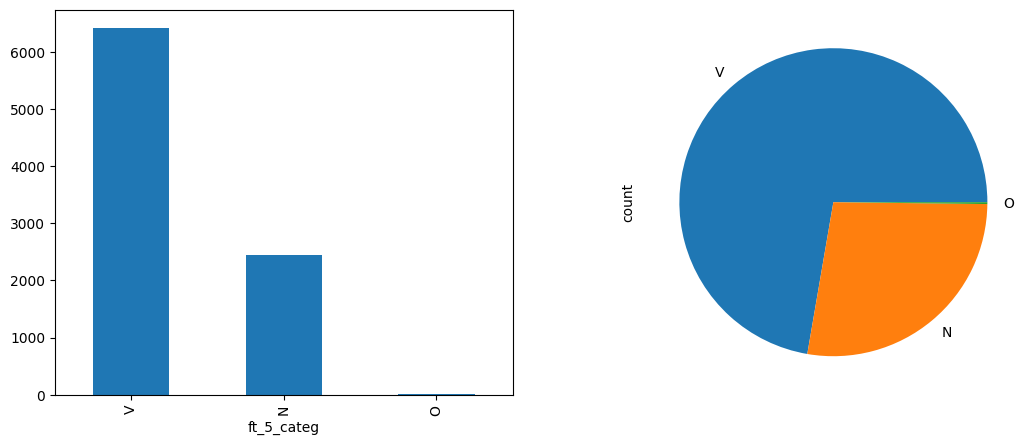

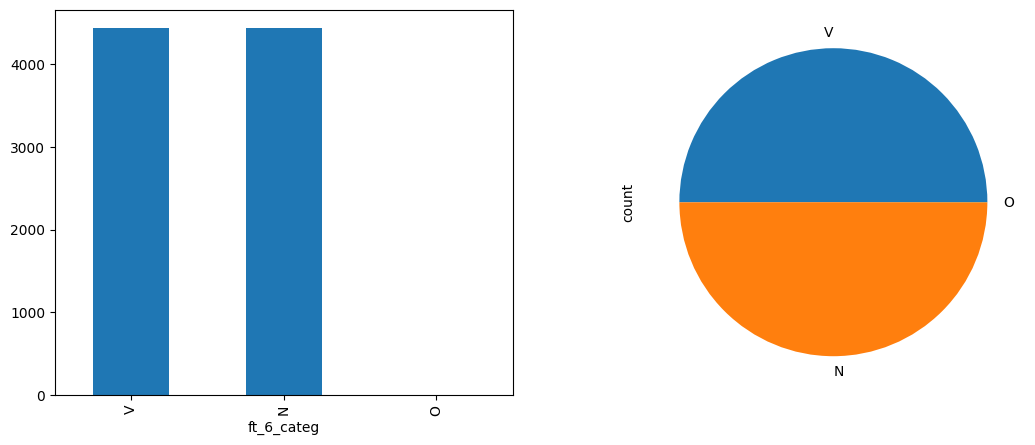

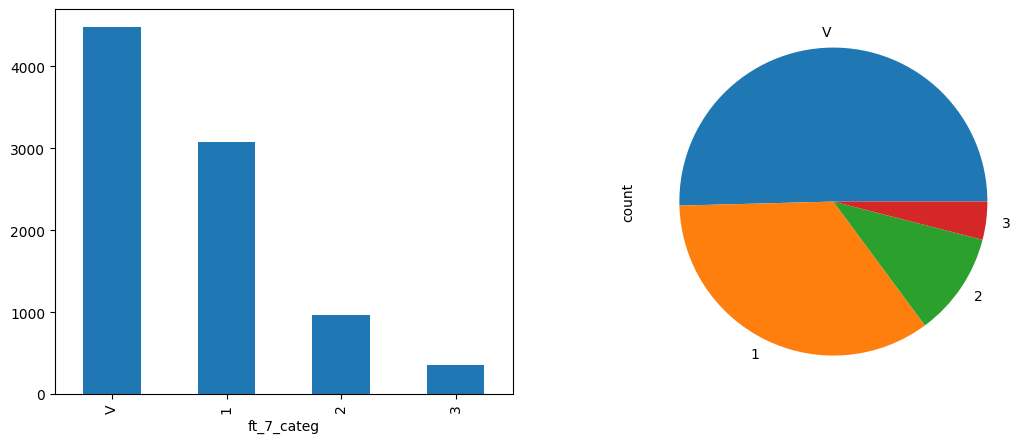

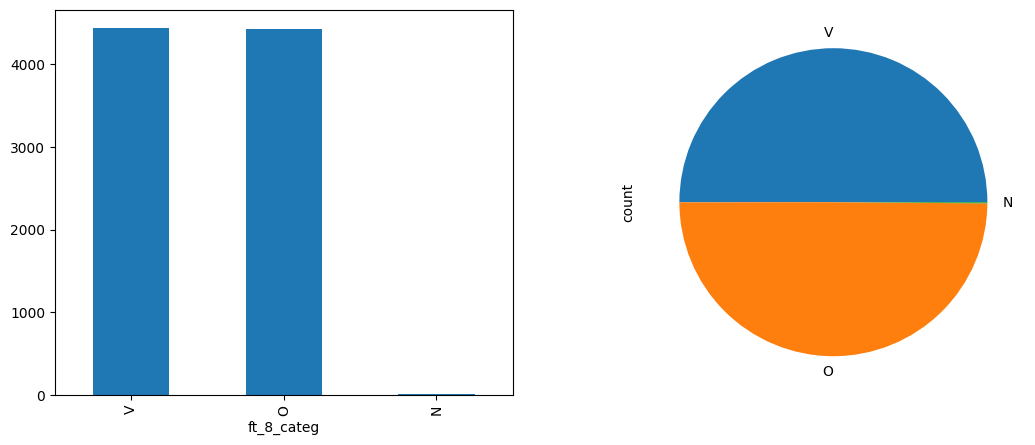

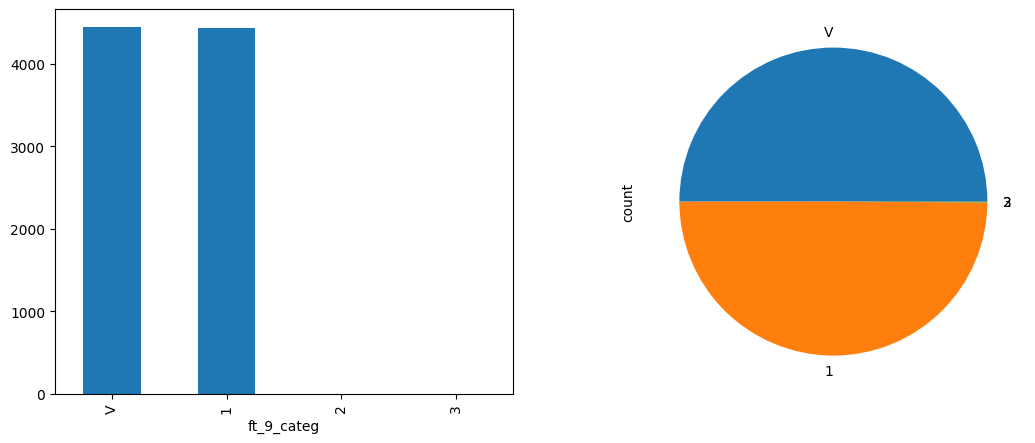

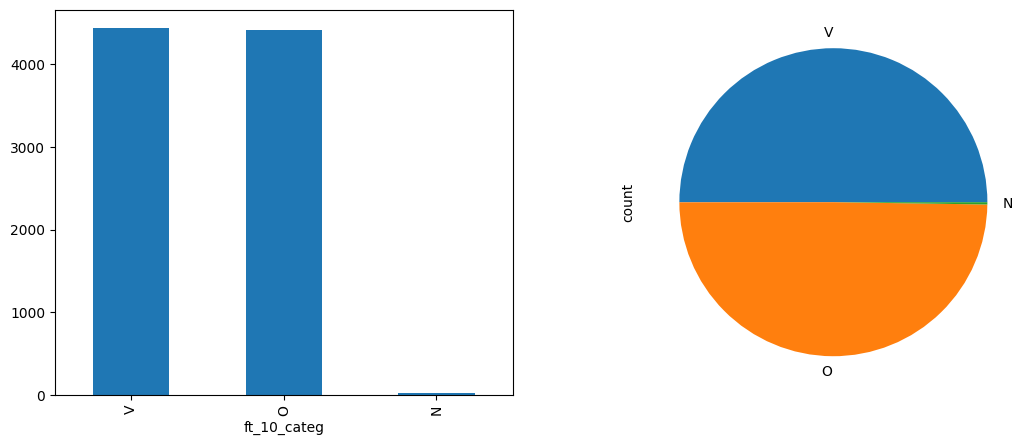

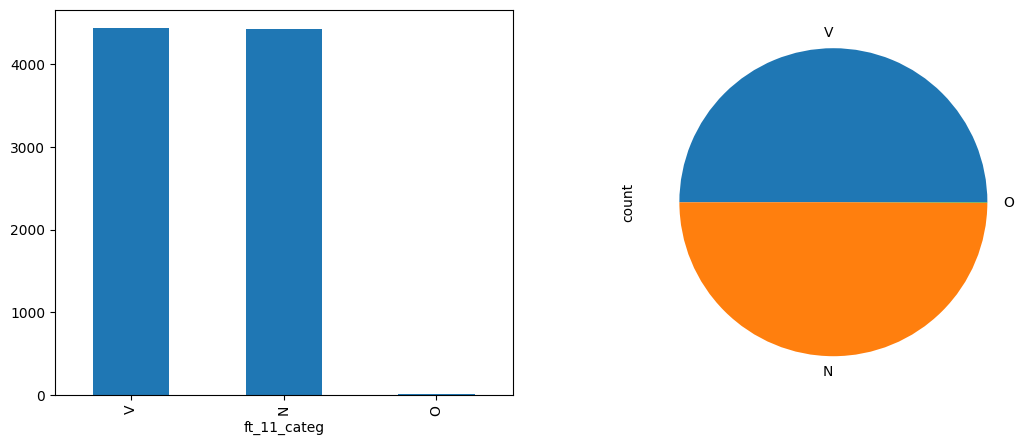

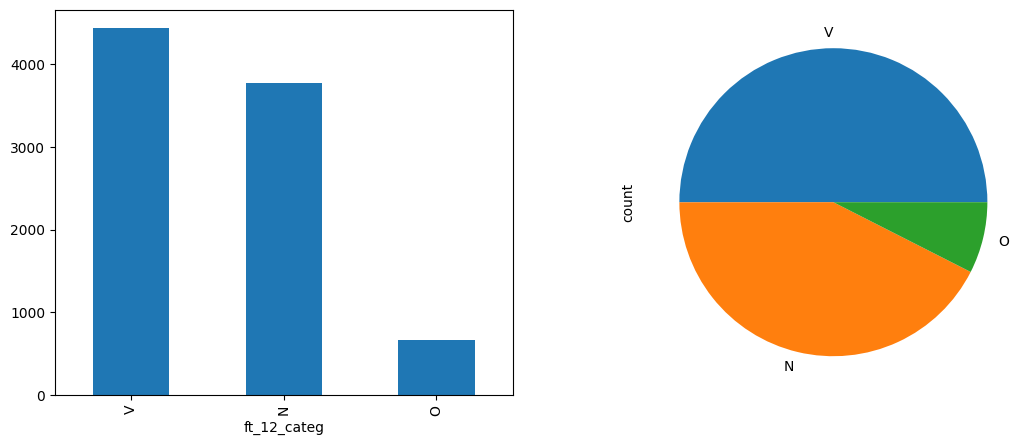

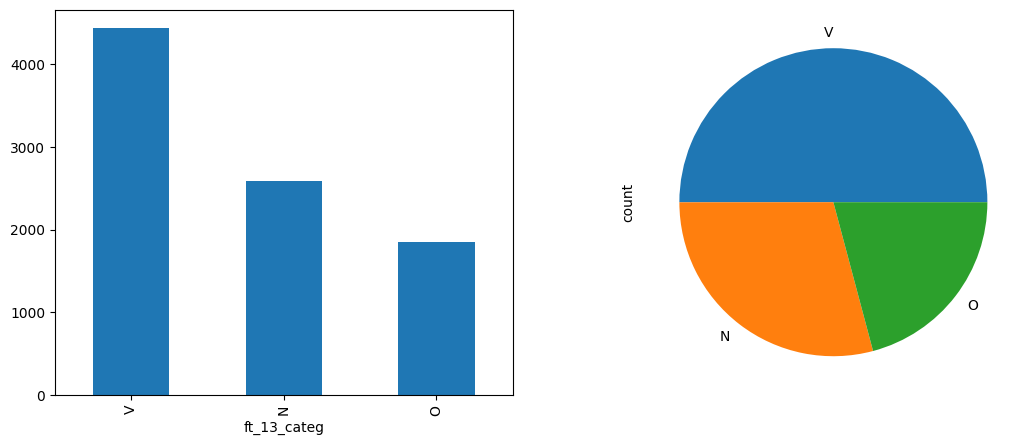

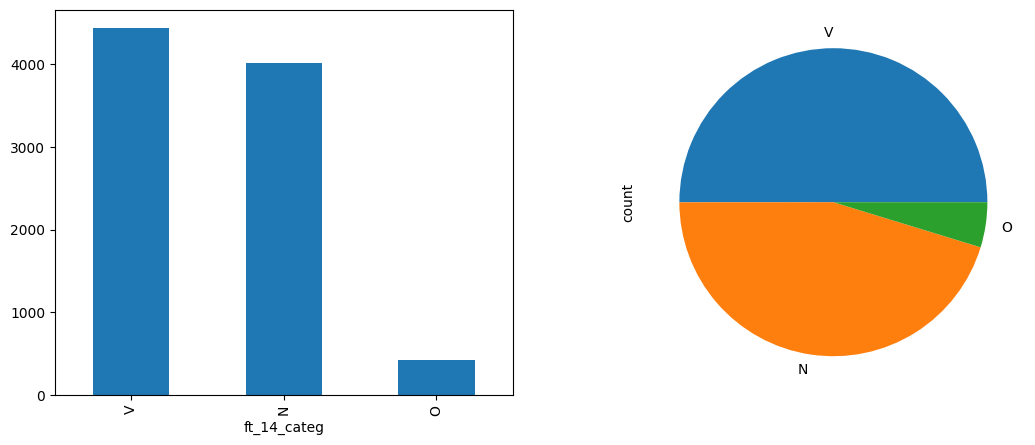

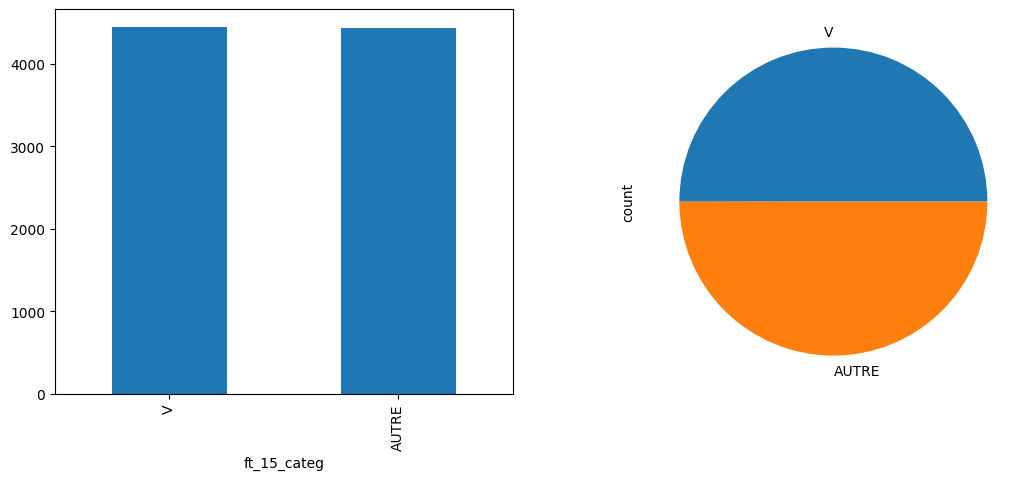

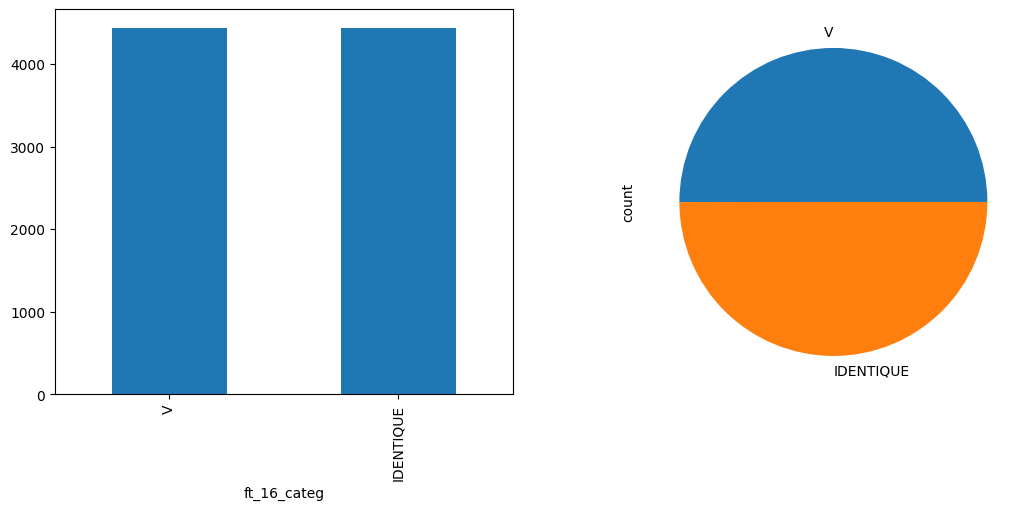

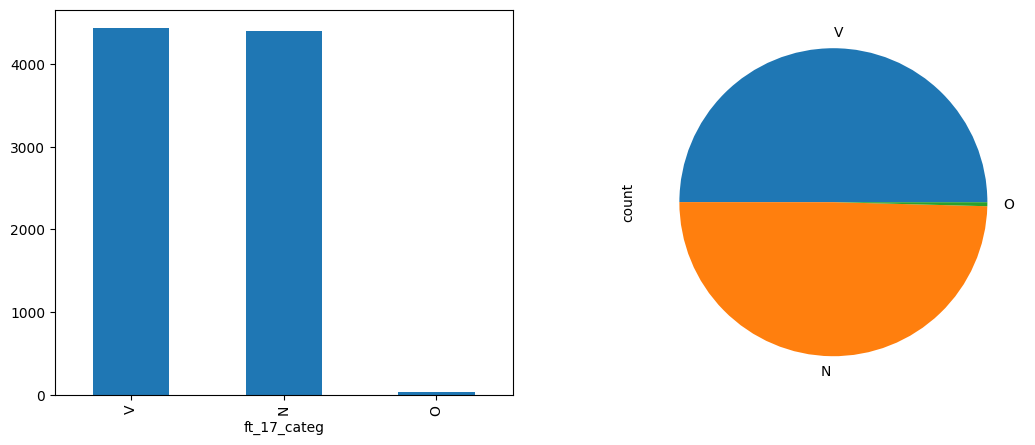

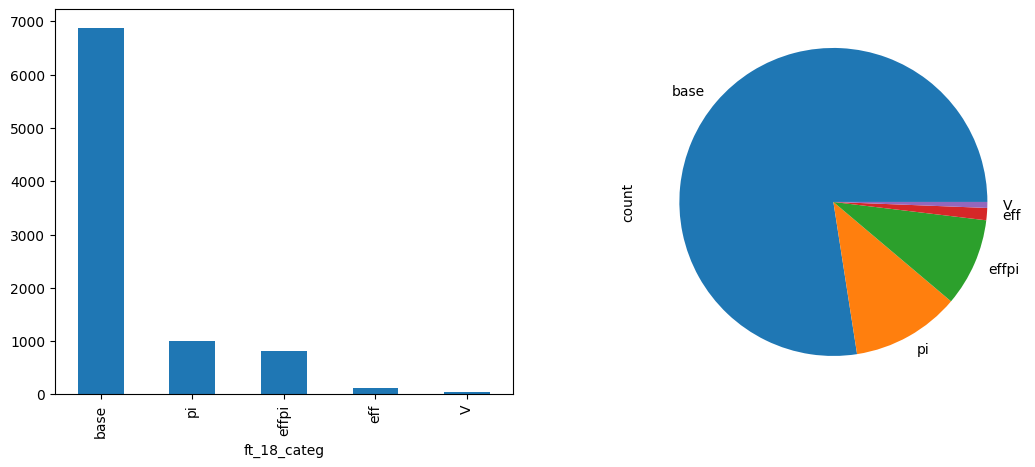

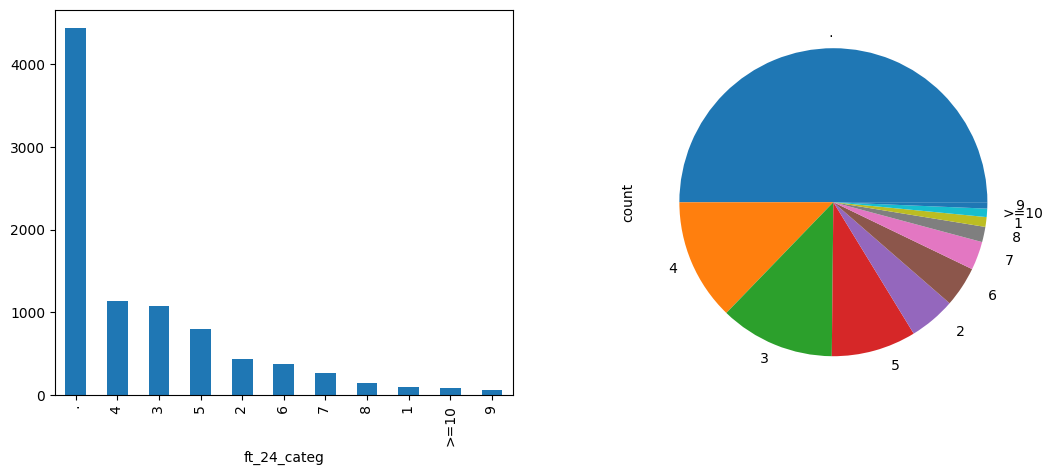

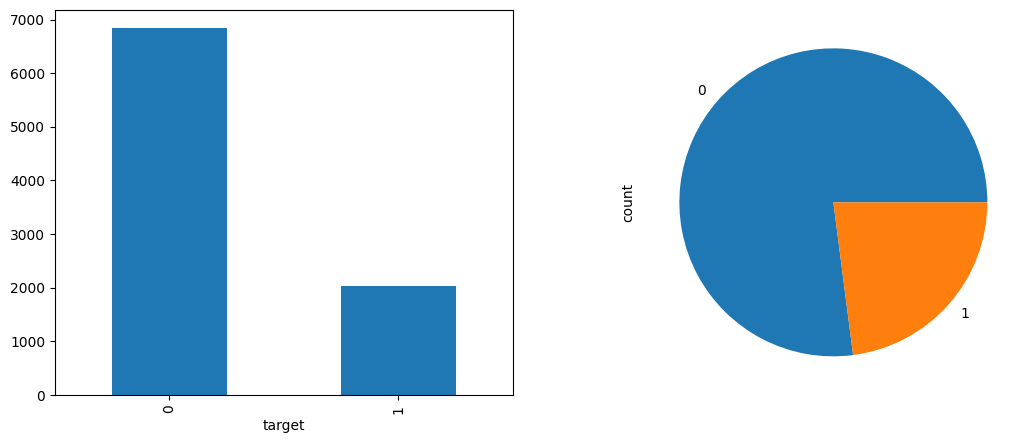

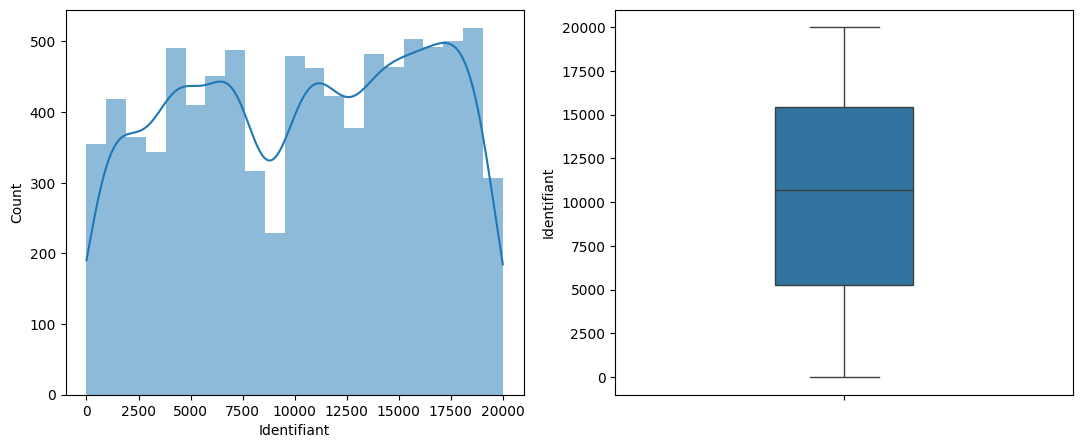

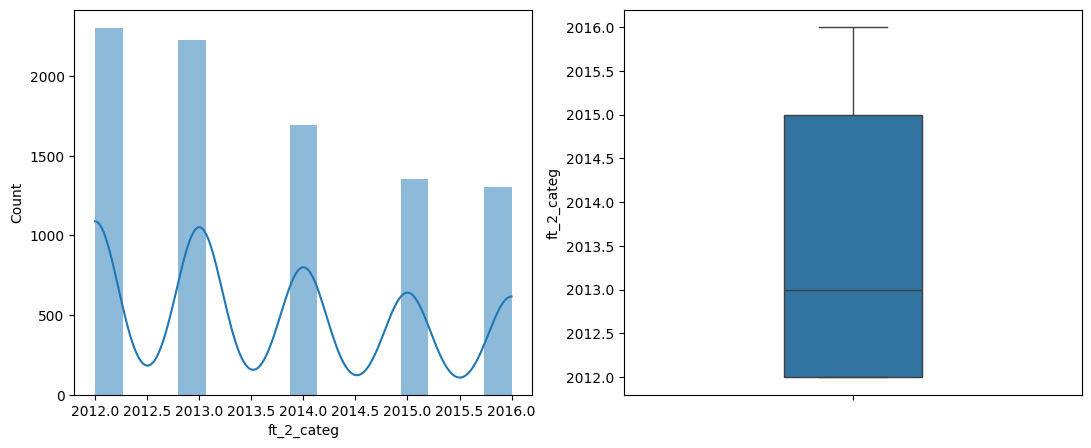

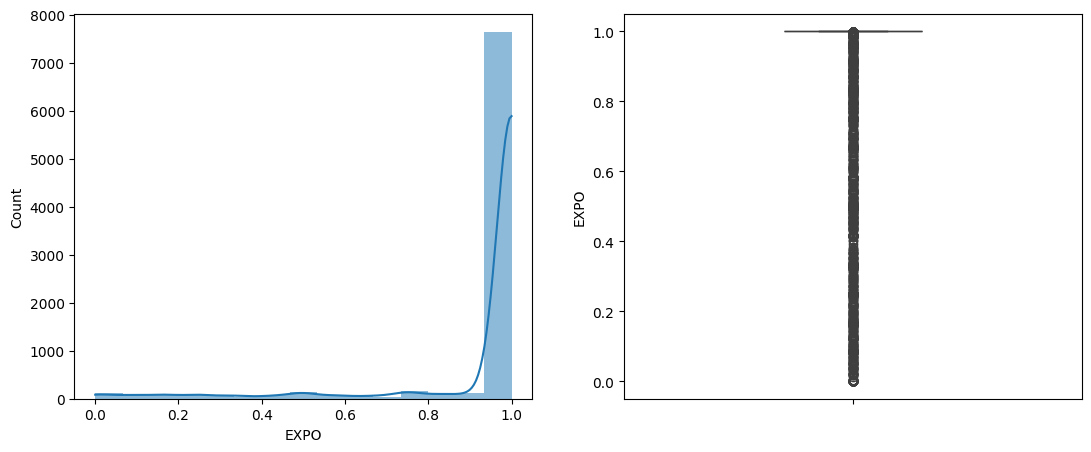

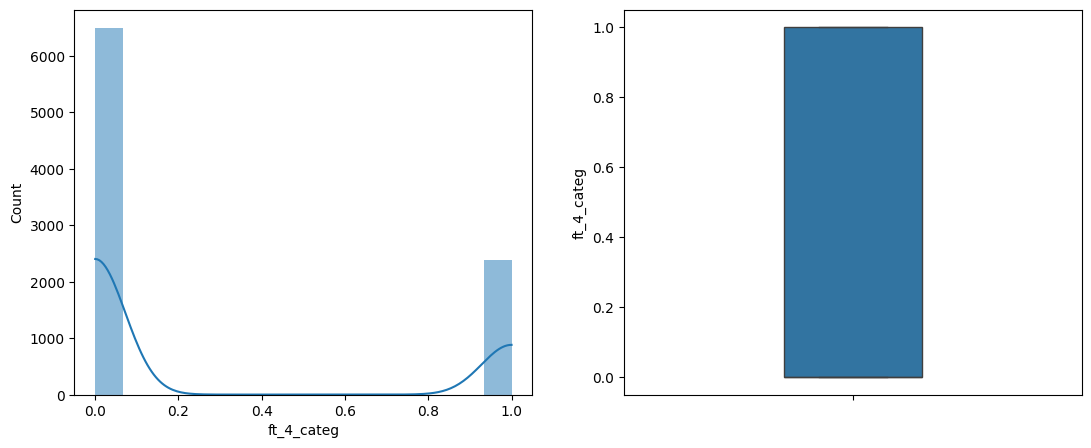

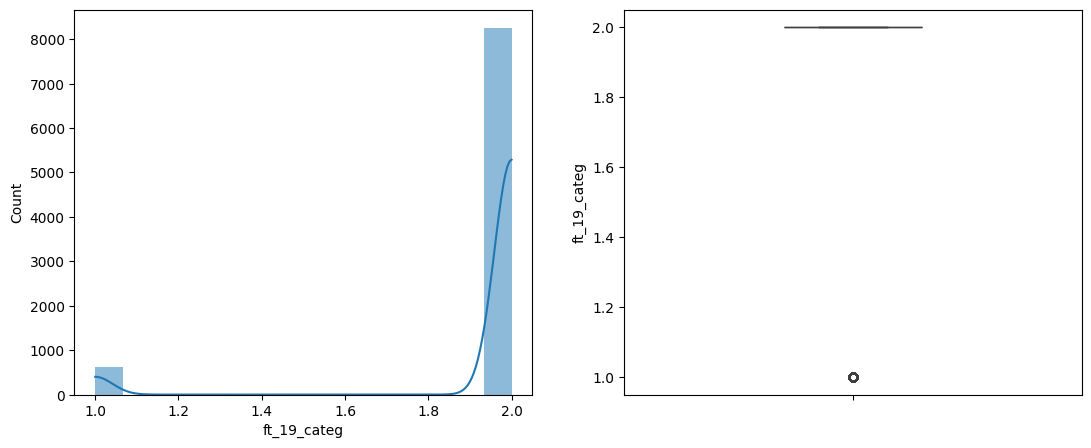

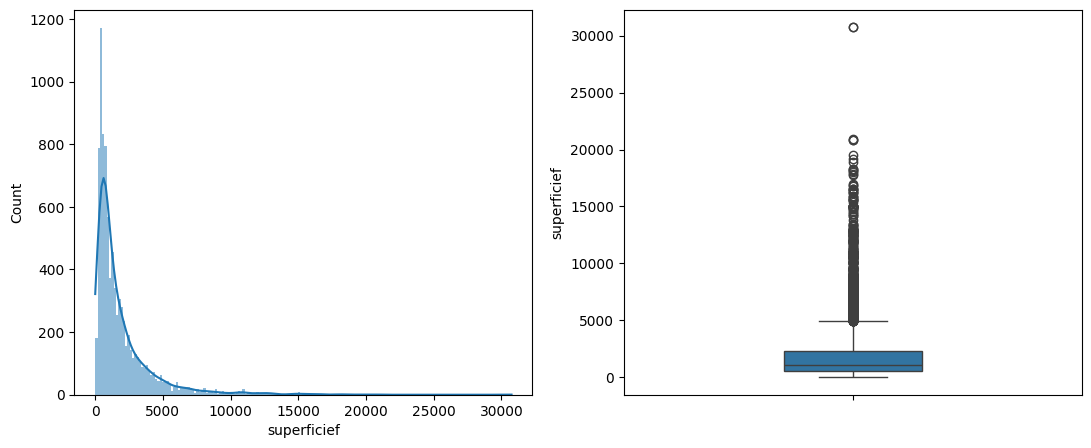

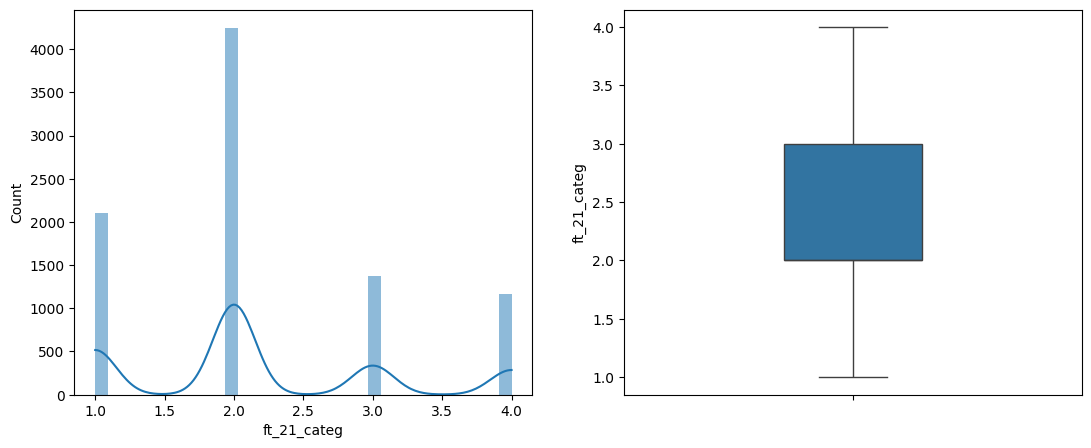

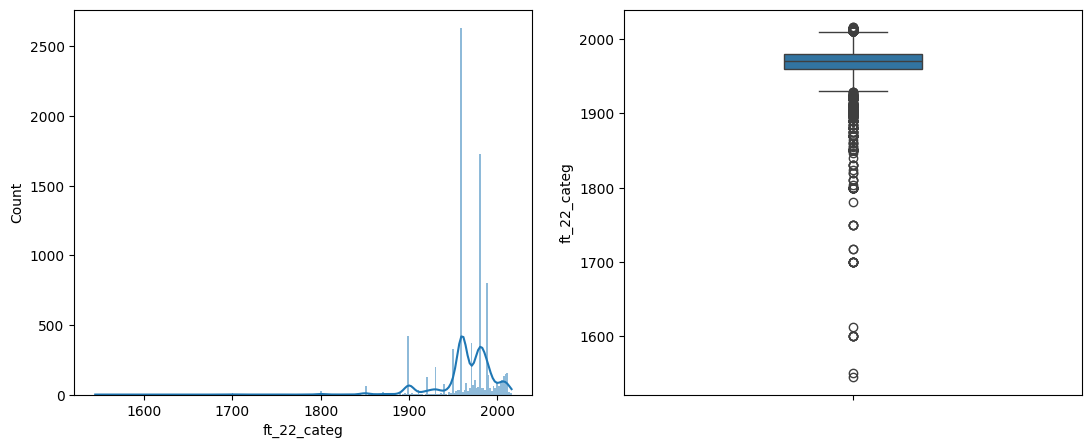

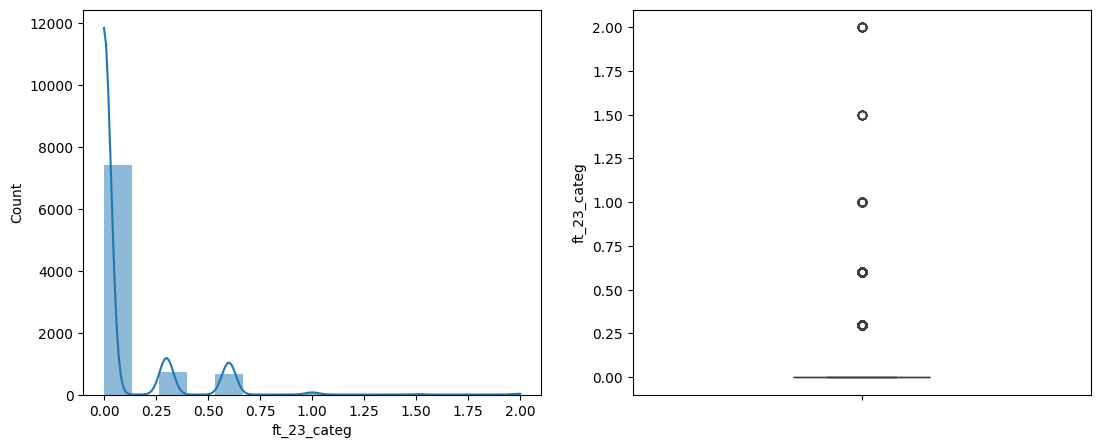

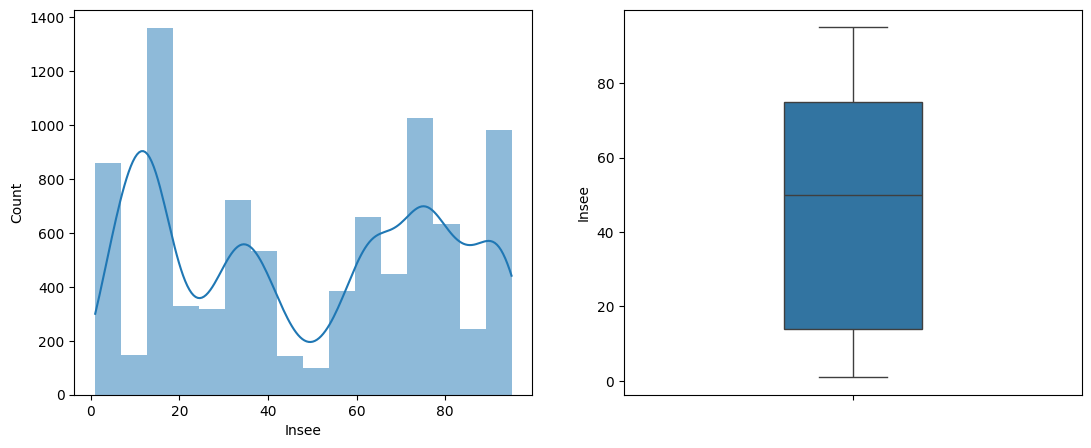

In [84]:
for col in clean_df.select_dtypes('object'):
    plt.figure(figsize=[13,5])

    plt.subplot(1,2,1)
    clean_df[col].value_counts().plot(kind="bar")
    
    plt.subplot(1,2,2)
    clean_df[col].value_counts().plot.pie()

    
for col in clean_df.select_dtypes(['float64', 'int64']):
    plt.figure(figsize=[13,5])

    plt.subplot(1,2,1)
    sns.histplot(clean_df[col], kde= True, edgecolor= None)

    plt.subplot(1,2,2)
    sns.boxplot(clean_df[col], width=0.3)

Correctif suite à l'analyse des graphes

In [85]:
clean_df['ft_4_categ'].value_counts()

ft_4_categ
0    6496
1    2382
Name: count, dtype: int64

Le graphique semble indiquer la présence des valeur 0 et 1 uniquement. On vérifie cela grâce à un value_count(). Le resultat nous permet de dire qu'il est nécessaire de transformer le type de l'objet en booléen.

In [86]:
clean_df['ft_4_categ'] = clean_df['ft_4_categ'].astype('int64').astype(object)

In [87]:
clean_df['ft_4_categ'].info()

<class 'pandas.core.series.Series'>
Index: 8878 entries, 0 to 10228
Series name: ft_4_categ
Non-Null Count  Dtype 
--------------  ----- 
8878 non-null   object
dtypes: object(1)
memory usage: 138.7+ KB


In [88]:
clean_df['ft_2_categ'].value_counts()

ft_2_categ
2012    2302
2013    2225
2014    1692
2015    1355
2016    1304
Name: count, dtype: int64

In [89]:
clean_df['ft_19_categ'] = clean_df['ft_19_categ'].astype('int64').astype(object)

In [90]:
clean_df['ft_19_categ'].info()

<class 'pandas.core.series.Series'>
Index: 8878 entries, 0 to 10228
Series name: ft_19_categ
Non-Null Count  Dtype 
--------------  ----- 
8878 non-null   object
dtypes: object(1)
memory usage: 138.7+ KB


In [91]:
clean_df[clean_df['ft_5_categ'] == 'O']

,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,...,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee,target
1068,5150,2014,1.000000,1,O,V,V,V,V,V,...,N,base,2,1956.0,4,1988.0,0.0,.,6,1
1537,7395,2012,0.540984,0,O,V,V,V,V,V,...,N,base,2,175.0,1,1960.0,0.0,.,35,0
2316,11622,2013,0.747945,0,O,V,V,V,V,V,...,N,base,2,796.0,3,1960.0,0.0,.,38,1
2416,11214,2015,1.000000,0,O,V,V,V,V,V,...,N,base,2,2280.0,1,1980.0,0.0,.,54,0
3423,11484,2016,0.997268,0,O,V,V,V,V,V,...,N,base,2,400.0,2,1960.0,0.0,.,13,0
5482,11213,2013,1.000000,0,O,V,V,V,V,V,...,N,base,2,2280.0,1,1980.0,0.0,.,54,1
5591,11998,2012,1.000000,0,O,V,V,V,V,V,...,N,base,2,3465.0,3,1980.0,0.0,.,38,1
5618,11730,2014,1.000000,1,O,V,V,V,V,V,...,N,base,2,700.0,4,1960.0,0.0,.,75,0
6390,11141,2013,0.315068,1,O,V,V,V,V,V,...,N,base,2,350.0,1,1980.0,0.0,.,54,0
6553,10775,2013,0.876712,0,O,V,V,V,V,V,...,N,base,2,335.0,3,1980.0,0.0,.,59,0


In [92]:
clean_df[clean_df['ft_6_categ'] == 'O']


,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,...,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee,target
8641,15166,2013,1.0,0,V,O,3,O,1,O,...,V,base,2,1500.0,2,1975.0,0.0,>=10,62,1


In [93]:
clean_df[clean_df['ft_11_categ'] == 'O']

,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,...,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee,target
489,5768,2016,0.584699,0,V,N,2,O,1,O,...,V,pi,1,441.0,4,1950.0,0.0,3,75,0
4412,2380,2014,1.000000,0,V,N,1,O,1,O,...,V,effpi,2,600.0,2,1988.0,0.0,2,83,1
4793,18814,2013,1.000000,0,V,N,3,O,1,O,...,V,base,1,470.0,2,1900.0,0.3,4,78,0
7624,18813,2012,0.341530,0,V,N,3,O,1,O,...,V,base,1,470.0,2,1900.0,0.3,4,78,0
9648,3651,2013,1.000000,0,V,N,1,O,1,O,...,V,effpi,1,650.0,1,1996.0,0.3,3,36,0


In [94]:
clean_df[clean_df['ft_17_categ'] == 'O']

,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,...,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee,target
221,2282,2014,0.471233,0,V,V,V,V,V,V,...,O,base,2,465.0,2,1980.0,0.0,.,62,0
228,7264,2014,1.000000,0,V,V,V,V,V,V,...,O,base,2,1800.0,1,1988.0,0.0,.,86,1
451,938,2013,1.000000,0,V,V,V,V,V,V,...,O,base,2,1100.0,2,1980.0,0.0,.,11,0
839,3593,2013,1.000000,0,V,V,V,V,V,V,...,O,base,2,735.0,2,1988.0,0.0,.,38,0
893,12358,2012,0.366120,0,N,V,V,V,V,V,...,O,base,2,250.0,2,1980.0,0.0,.,59,0
989,5956,2014,1.000000,0,V,V,V,V,V,V,...,O,base,2,2000.0,2,1980.0,0.0,.,11,0
1691,3474,2013,0.320548,0,V,V,V,V,V,V,...,O,base,2,2293.0,2,1988.0,0.0,.,38,1
2112,417,2015,1.000000,0,V,V,V,V,V,V,...,O,base,2,1050.0,2,1980.0,0.0,.,11,0
2500,12454,2013,0.161644,1,N,V,V,V,V,V,...,O,base,2,860.0,4,1988.0,0.0,.,6,0
2650,7927,2015,1.000000,0,V,V,V,V,V,V,...,O,base,2,1700.0,2,1988.0,0.0,.,38,1


On choisit de supprimer uniquement la ligne de la colonne ft_6_categ comportant un 'O' pour éviter le sur-apprentissage. On choisit de conserver les autres lignes car leur quantité est plus importante. On ne peut pas exclure leur influence sur la variable cible

In [95]:
clean_df = clean_df[clean_df['ft_6_categ'] != 'O']
clean_df = clean_df[clean_df['ft_5_categ'] != 'O']
clean_df = clean_df[clean_df['ft_11_categ'] != 'O']

In [96]:
clean_df[clean_df['ft_8_categ'] == 'N']

,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,...,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee,target
2542,12345,2015,1.000000,0,V,N,1,N,1,N,...,V,pi,1,1783.0,1,2005.0,0.6,2,74,0
3007,1571,2013,1.000000,0,V,N,1,N,1,O,...,V,V,2,6203.0,1,1990.0,0.0,5,74,0
3064,6581,2012,1.000000,0,V,N,1,N,1,O,...,V,base,2,3900.0,1,1976.0,0.0,5,61,0
4392,5797,2014,1.000000,0,V,N,1,N,1,O,...,V,pi,2,350.0,1,1960.0,0.0,3,74,0
4939,5796,2012,1.000000,0,V,N,1,N,1,O,...,V,pi,2,350.0,1,1960.0,0.0,3,74,0
5026,9933,2016,0.710383,0,V,N,2,N,1,O,...,V,effpi,2,3326.0,1,1975.0,0.6,6,74,0
6379,12344,2014,1.000000,0,V,N,1,N,1,N,...,V,pi,1,1783.0,1,2005.0,0.6,2,74,0
6883,3915,2013,1.000000,0,V,N,1,N,1,O,...,V,eff,1,760.0,1,1969.0,0.6,4,73,0
6915,1039,2014,1.000000,0,V,N,3,N,1,N,...,V,base,2,155.0,2,1980.0,0.0,1,62,0
6943,6582,2013,1.000000,0,V,N,1,N,1,O,...,V,base,2,3900.0,1,1976.0,0.0,5,61,1


In [97]:
clean_df[clean_df['ft_10_categ'] == 'N']

,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,...,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee,target
121,17796,2015,0.983562,1,V,N,1,O,1,N,...,V,base,2,300.0,1,2005.0,0.3,3,74,0
774,11663,2015,1.000000,0,V,N,1,O,1,N,...,V,pi,1,350.0,1,2000.0,0.0,2,74,0
936,2673,2012,1.000000,0,V,N,1,O,1,N,...,V,pi,2,615.0,1,1968.0,0.0,3,74,0
966,17485,2014,1.000000,0,V,N,1,O,1,N,...,V,base,2,240.0,1,1850.0,0.0,3,10,0
1063,17486,2016,0.997268,0,V,N,1,O,1,N,...,V,base,2,240.0,1,1850.0,0.0,3,10,0
1106,7267,2013,1.000000,0,V,N,1,O,1,N,...,V,pi,2,470.0,2,1900.0,0.0,4,38,0
1794,17107,2016,1.000000,0,V,N,1,O,1,N,...,V,base,2,400.0,1,1700.0,0.6,3,10,1
2103,13902,2014,1.000000,1,V,N,2,O,1,N,...,V,pi,2,1052.0,2,1977.0,0.6,5,76,1
2327,20,2016,0.997268,0,V,N,1,O,1,N,...,V,pi,1,968.0,2,1915.0,0.0,3,38,0
2542,12345,2015,1.000000,0,V,N,1,N,1,N,...,V,pi,1,1783.0,1,2005.0,0.6,2,74,0


On choisit de garder ces valeurs, on ne peut pas exclure leur influence

In [98]:
clean_df[clean_df['ft_9_categ'] == '2']

,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,...,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee,target
70,15816,2013,1.000000,0,V,N,2,O,2,O,...,V,effpi,2,19195.0,2,1970.0,0.0,6,60,1
1512,15176,2016,0.997268,0,V,N,2,O,2,O,...,V,pi,2,4430.0,1,1975.0,0.0,5,86,0
1894,17672,2014,1.000000,0,V,N,1,O,2,O,...,V,pi,1,1089.0,2,1824.0,0.3,4,57,1
4119,16348,2012,1.000000,0,V,N,1,O,2,O,...,V,pi,2,400.0,1,1900.0,0.0,3,54,0
5518,17351,2015,1.000000,1,V,N,1,O,2,O,...,V,base,2,2050.0,2,1923.0,0.3,8,69,0
8152,9820,2013,1.000000,0,V,N,1,O,2,O,...,V,pi,1,790.0,2,1900.0,0.0,3,90,0
8705,1447,2016,0.994536,0,V,N,1,O,2,O,...,V,pi,2,828.0,2,1900.0,0.0,3,21,0


In [99]:
clean_df[clean_df['ft_9_categ'] == '3']

,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_9_categ,ft_10_categ,...,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee,target
1843,19418,2014,1.0,0,V,N,1,O,3,O,...,V,base,2,420.0,2,1960.0,0.6,3,78,0


In [100]:
clean_df = clean_df[clean_df['ft_8_categ'] != 'N']
clean_df = clean_df[clean_df['ft_9_categ'] != '2']
clean_df = clean_df[clean_df['ft_9_categ'] != '3']
clean_df['ft_8_categ'].value_counts()


ft_8_categ
V    4423
O    4413
Name: count, dtype: int64

In [101]:
clean_df['ft_9_categ'].value_counts()

ft_9_categ
V    4423
1    4413
Name: count, dtype: int64

Nous remarquons que les deux colonnes ont autant de V et que le nombre de O correspond au nombre de 1. Nous allons verifier si ces couples (V,V) et (O,1) correspondent aux meme lignes.

In [102]:
correspondance_V_V = clean_df[(clean_df['ft_8_categ'] == 'V') & (clean_df['ft_8_categ'] == 'V')]
print(correspondance_V_V.count())


Identifiant    4423
ft_2_categ     4423
EXPO           4423
ft_4_categ     4423
ft_5_categ     4423
ft_6_categ     4423
ft_7_categ     4423
ft_8_categ     4423
ft_9_categ     4423
ft_10_categ    4423
ft_11_categ    4423
ft_12_categ    4423
ft_13_categ    4423
ft_14_categ    4423
ft_15_categ    4423
ft_16_categ    4423
ft_17_categ    4423
ft_18_categ    4423
ft_19_categ    4423
superficief    4423
ft_21_categ    4423
ft_22_categ    4423
ft_23_categ    4423
ft_24_categ    4423
Insee          4423
target         4423
dtype: int64


In [103]:
correspondance_1_O = clean_df[(clean_df['ft_9_categ'] == '1') & (clean_df['ft_8_categ'] == 'O')]
print(correspondance_1_O.count())


Identifiant    4413
ft_2_categ     4413
EXPO           4413
ft_4_categ     4413
ft_5_categ     4413
ft_6_categ     4413
ft_7_categ     4413
ft_8_categ     4413
ft_9_categ     4413
ft_10_categ    4413
ft_11_categ    4413
ft_12_categ    4413
ft_13_categ    4413
ft_14_categ    4413
ft_15_categ    4413
ft_16_categ    4413
ft_17_categ    4413
ft_18_categ    4413
ft_19_categ    4413
superficief    4413
ft_21_categ    4413
ft_22_categ    4413
ft_23_categ    4413
ft_24_categ    4413
Insee          4413
target         4413
dtype: int64


Nous remarquons que les couples de valeurs de la colonne ft_8_categ et ft_9_categ sont toujours les memes, de ce fait nous pouvons supprimer une de ces deux colonnes car les deux colonnes auront le meme impact sur le résultat.

In [104]:
clean_df.drop(columns=['ft_9_categ'], inplace=True)

In [105]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8836 entries, 0 to 10228
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Identifiant  8836 non-null   int64  
 1   ft_2_categ   8836 non-null   int64  
 2   EXPO         8836 non-null   float64
 3   ft_4_categ   8836 non-null   object 
 4   ft_5_categ   8836 non-null   object 
 5   ft_6_categ   8836 non-null   object 
 6   ft_7_categ   8836 non-null   object 
 7   ft_8_categ   8836 non-null   object 
 8   ft_10_categ  8836 non-null   object 
 9   ft_11_categ  8836 non-null   object 
 10  ft_12_categ  8836 non-null   object 
 11  ft_13_categ  8836 non-null   object 
 12  ft_14_categ  8836 non-null   object 
 13  ft_15_categ  8836 non-null   object 
 14  ft_16_categ  8836 non-null   object 
 15  ft_17_categ  8836 non-null   object 
 16  ft_18_categ  8836 non-null   object 
 17  ft_19_categ  8836 non-null   object 
 18  superficief  8836 non-null   float64
 19  ft_21_cate

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_17804\477390759.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[13,5])


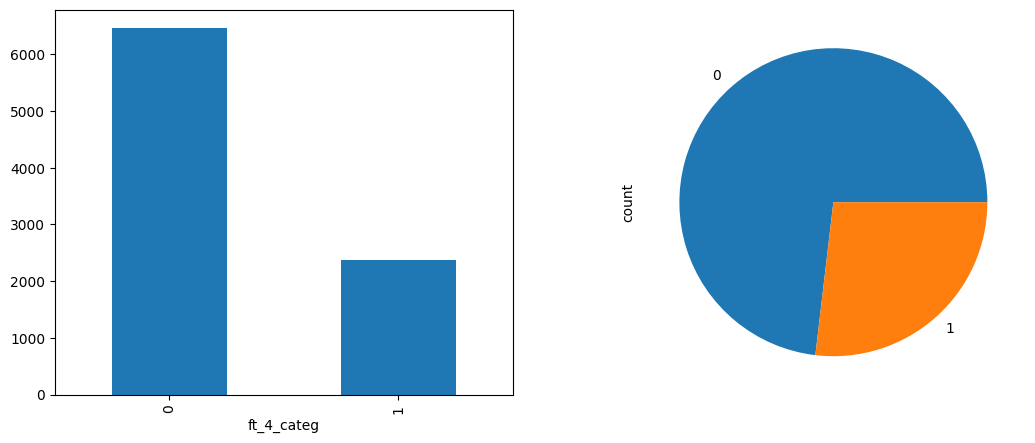

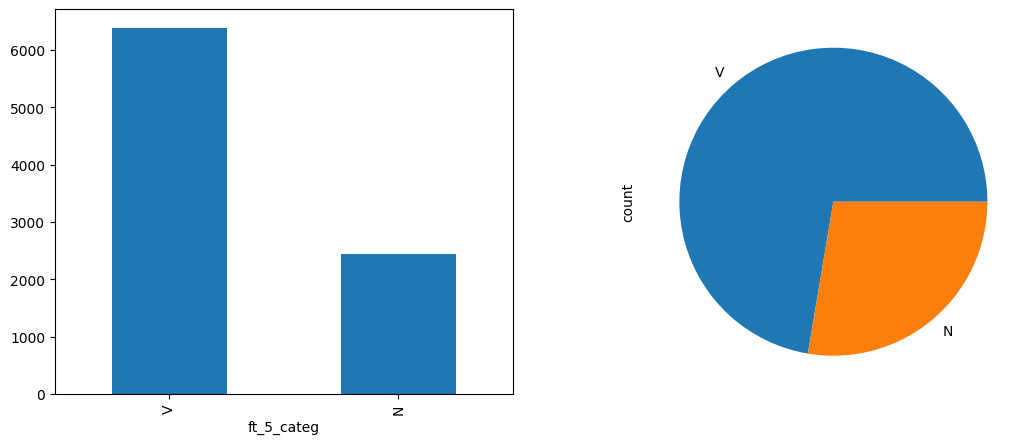

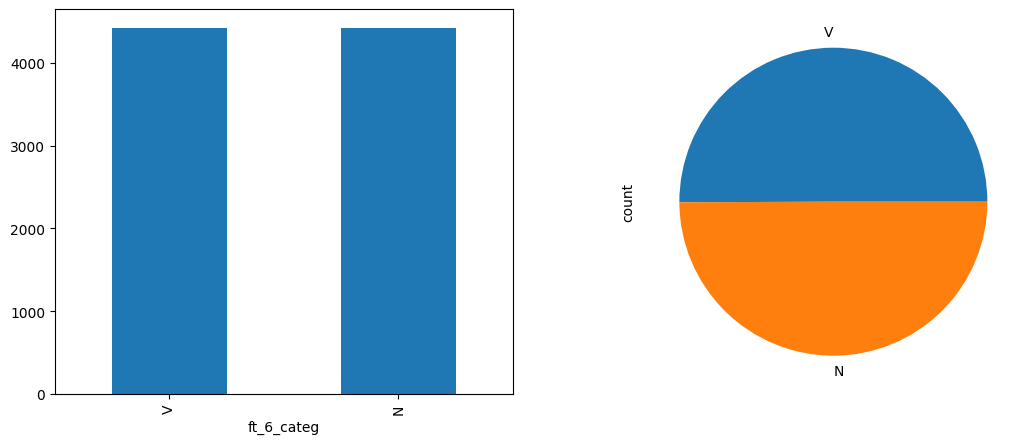

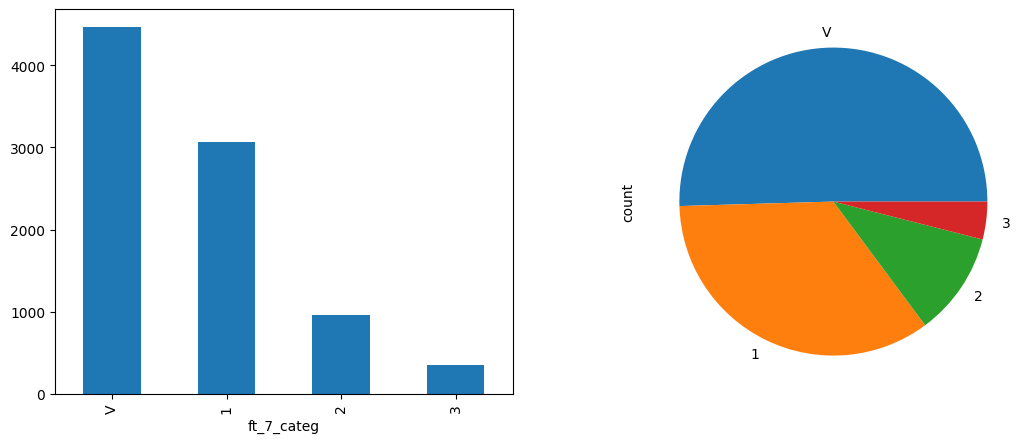

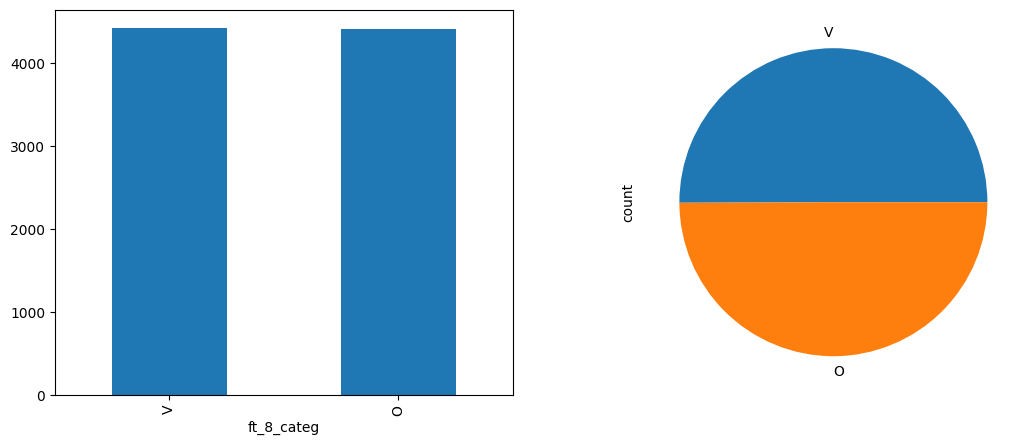

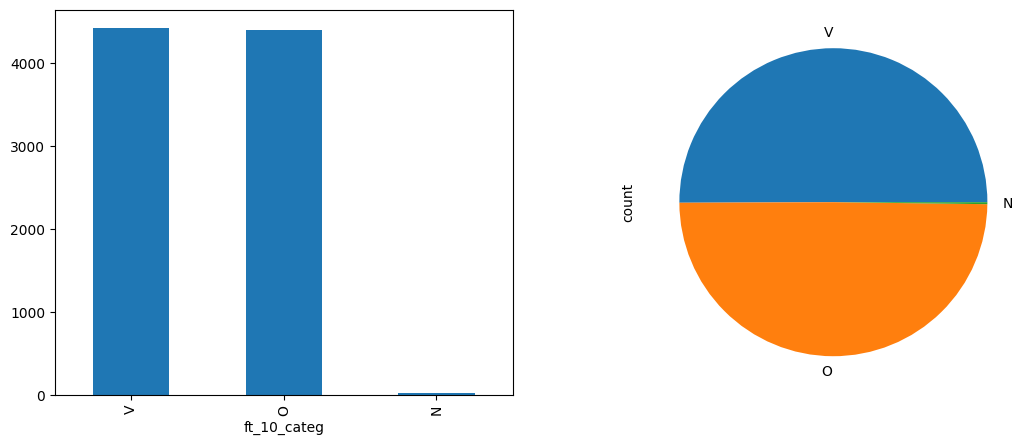

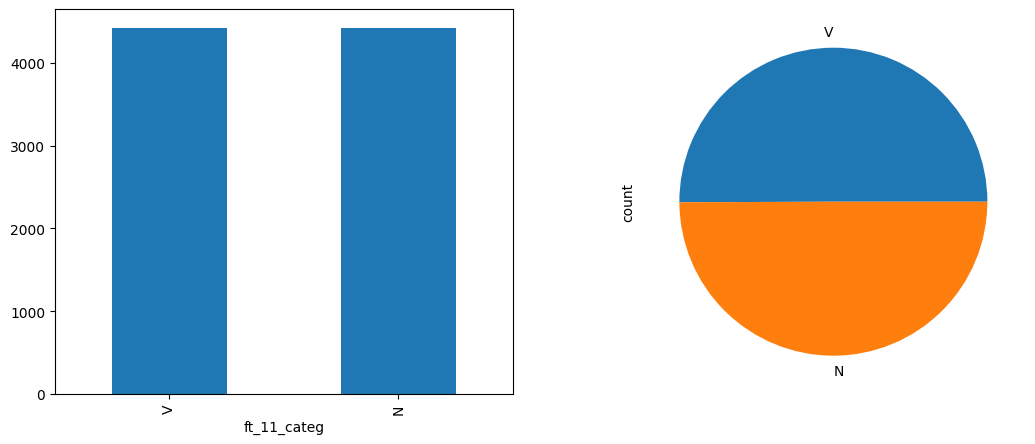

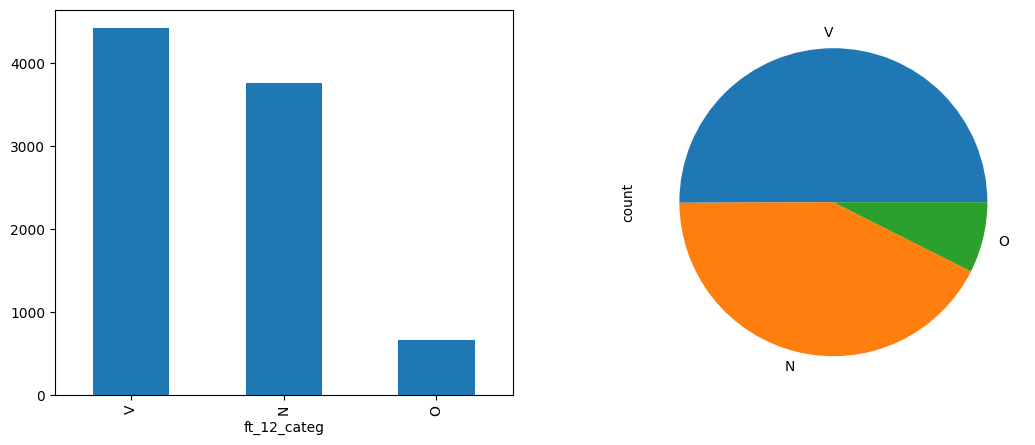

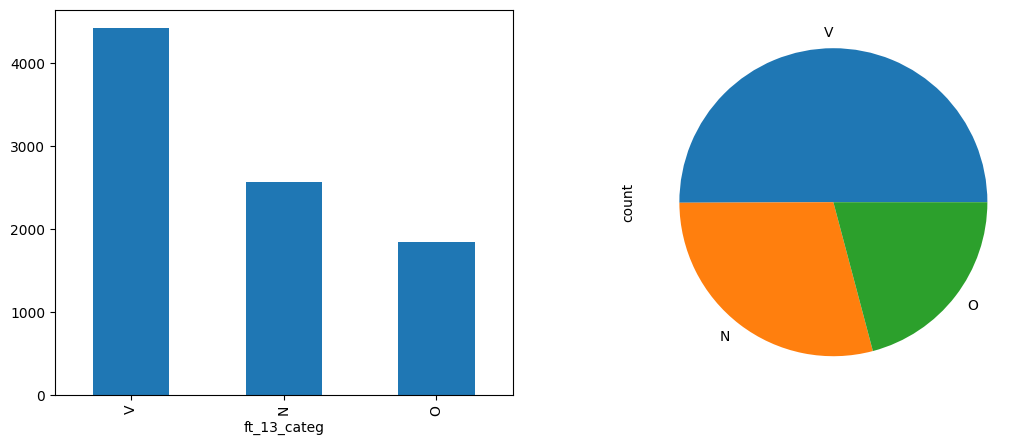

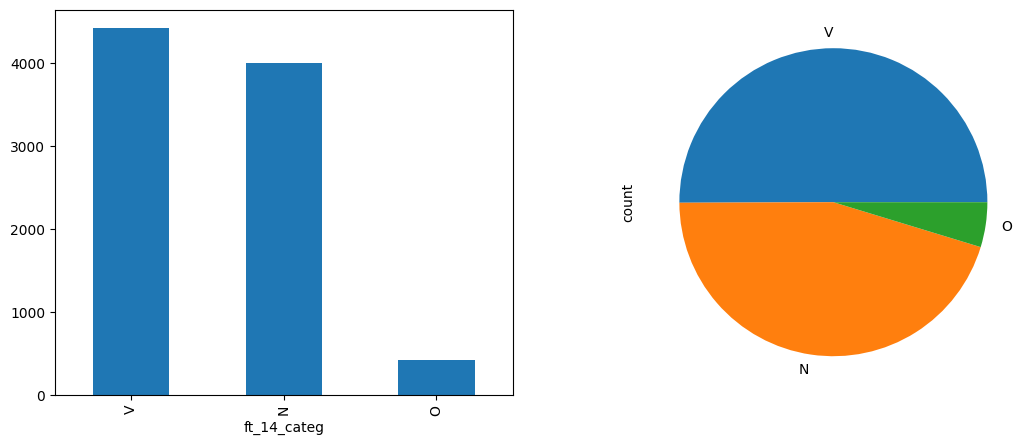

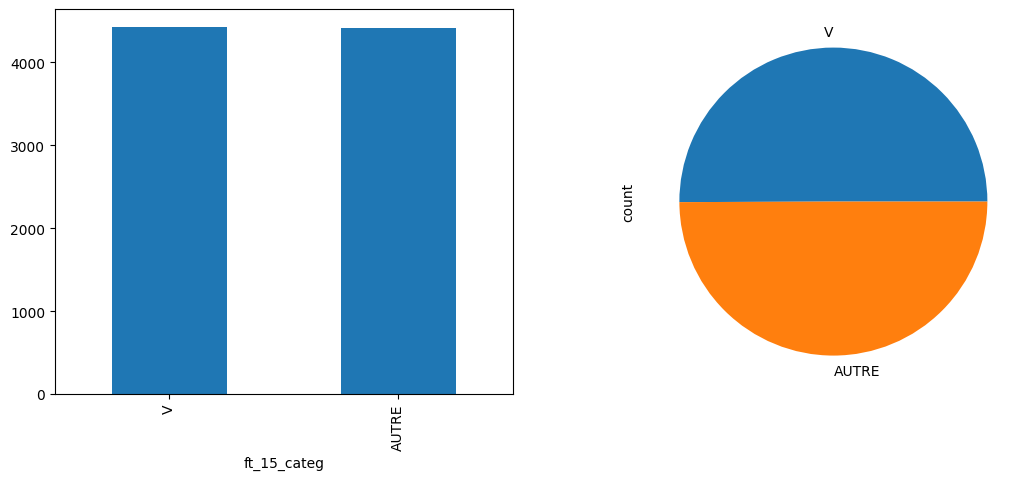

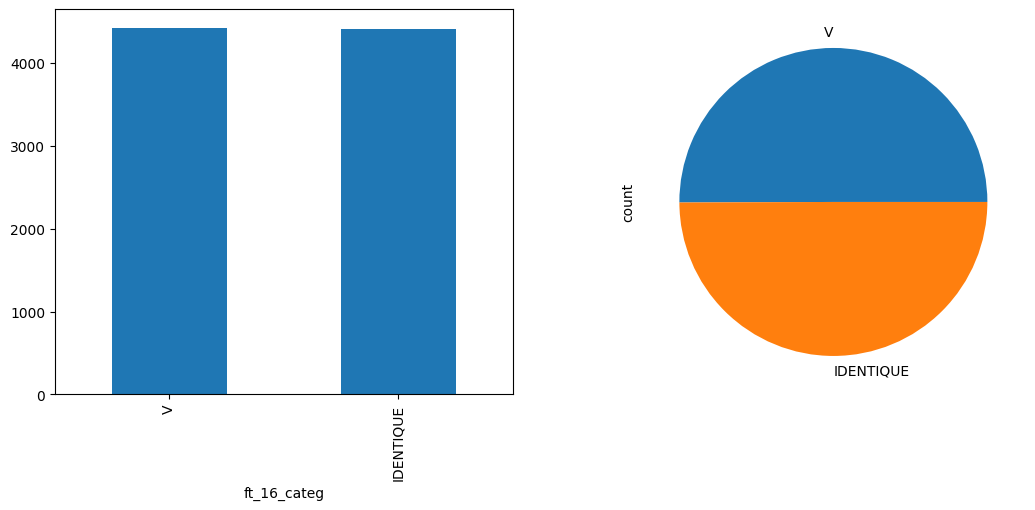

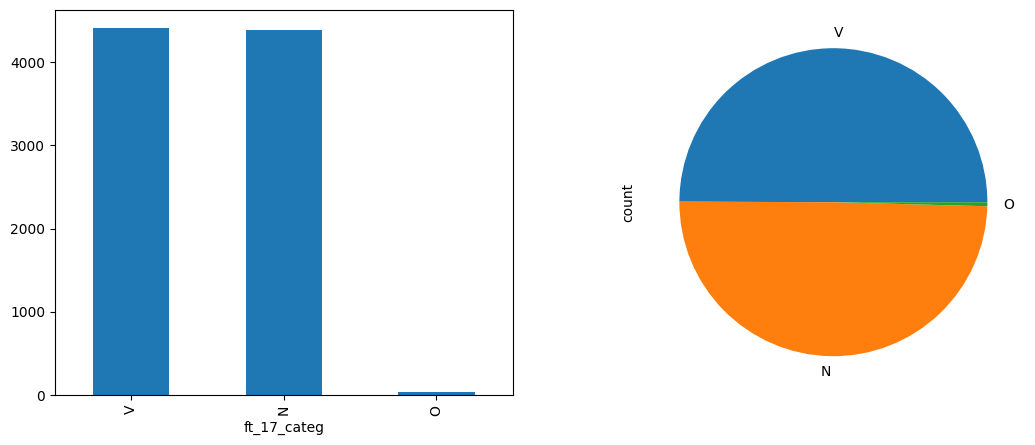

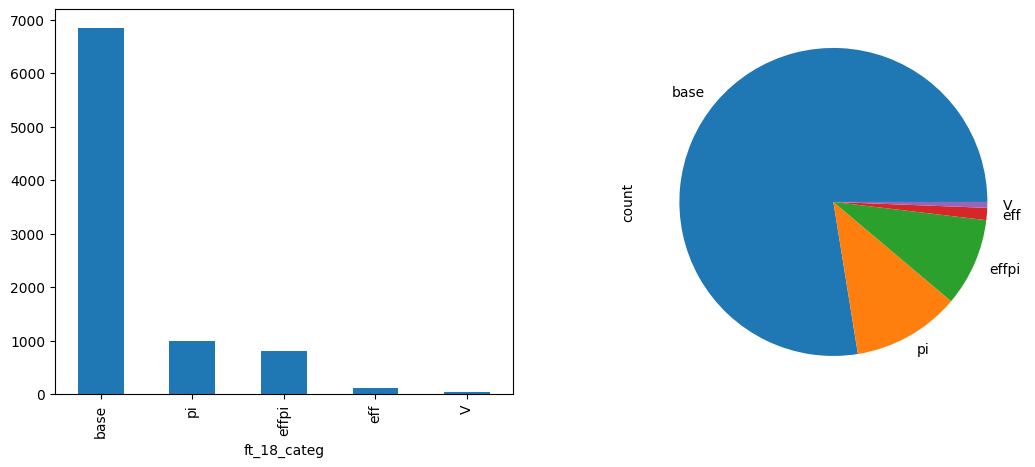

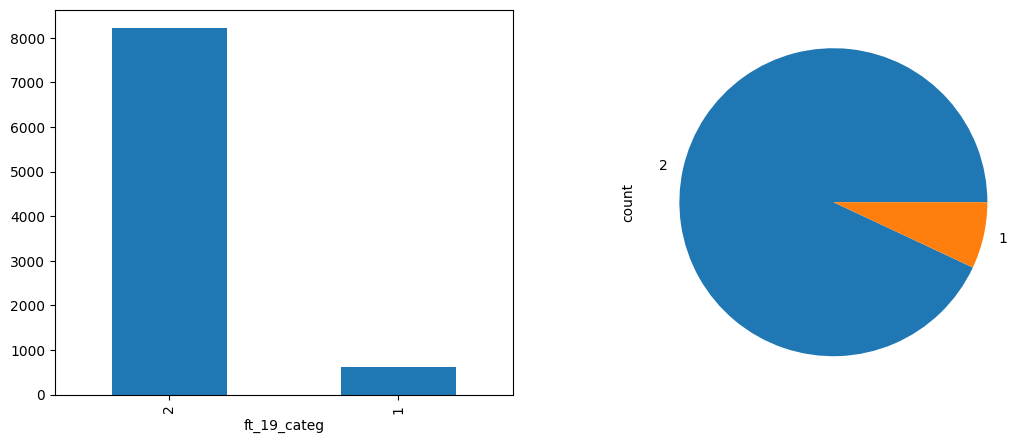

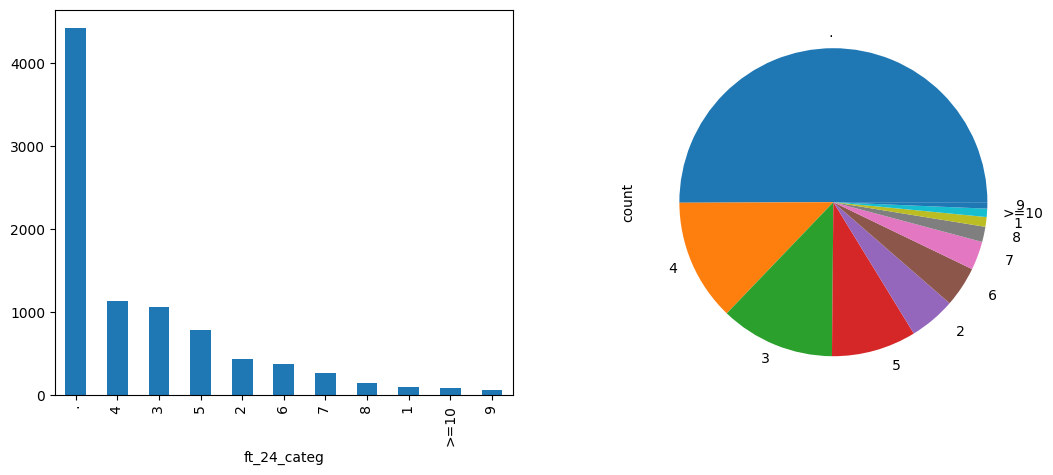

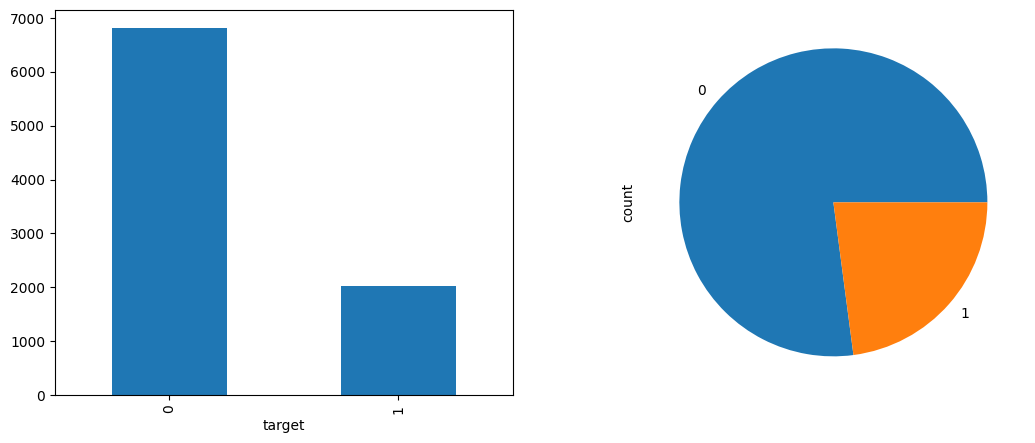

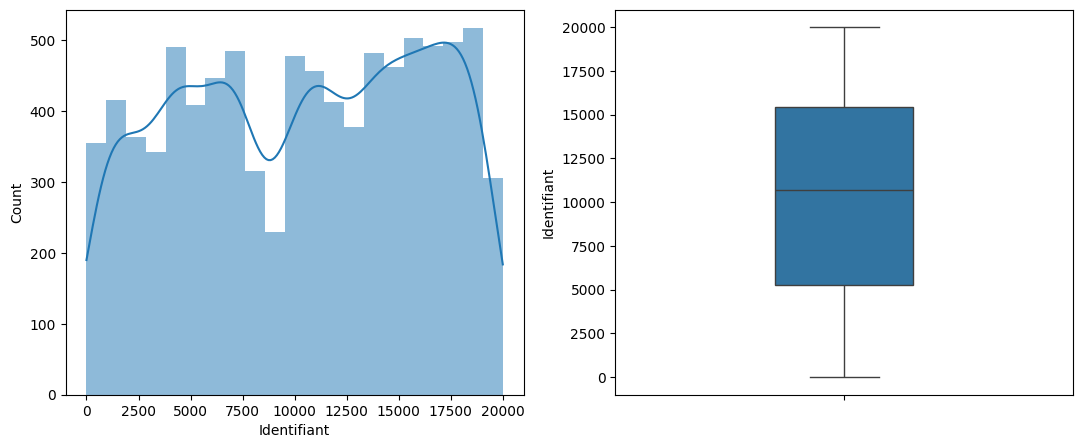

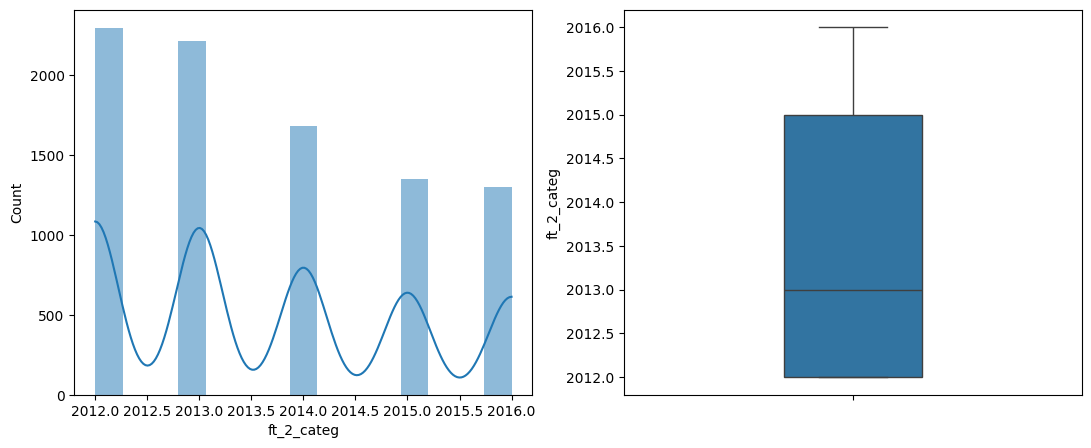

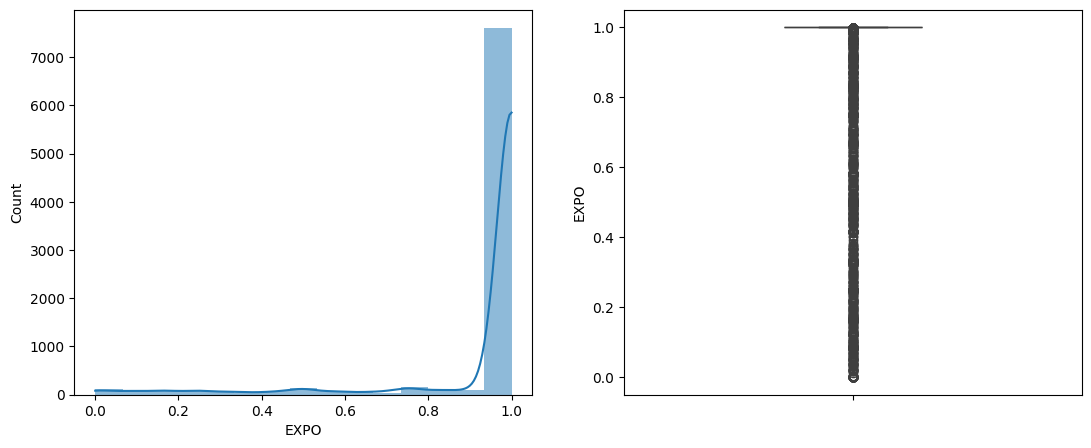

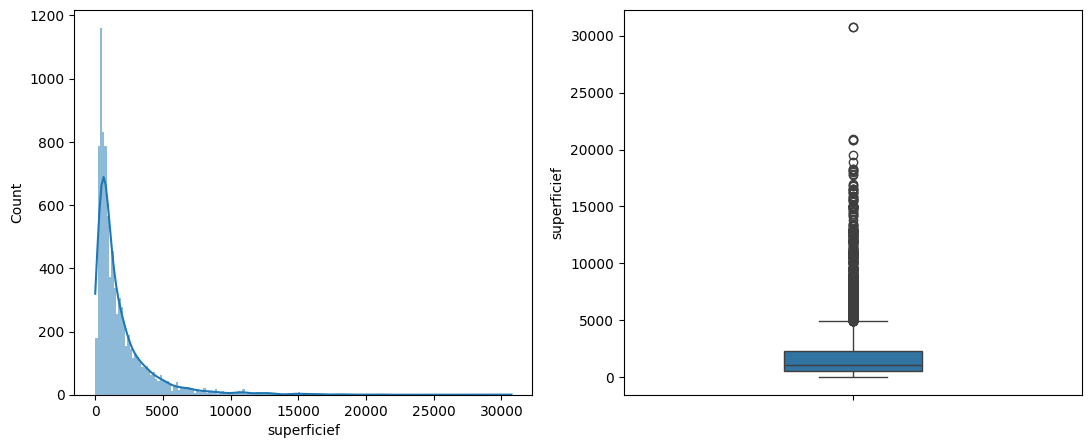

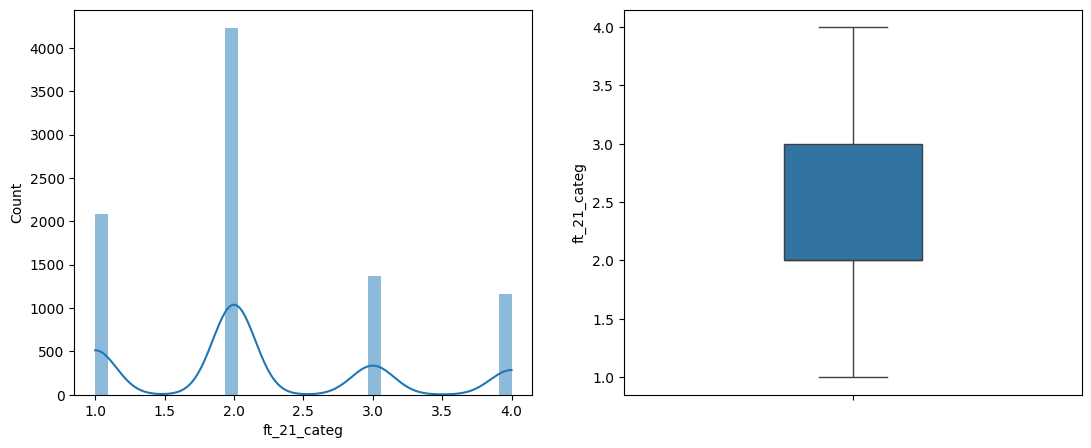

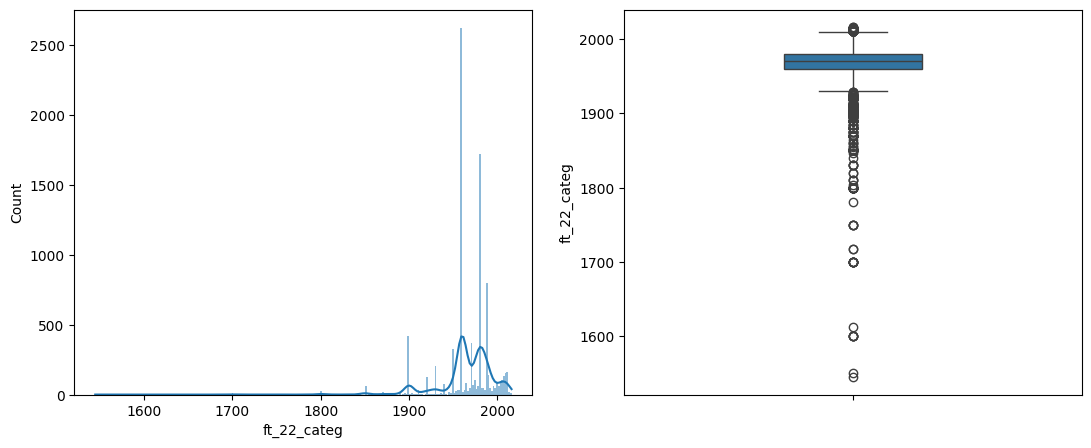

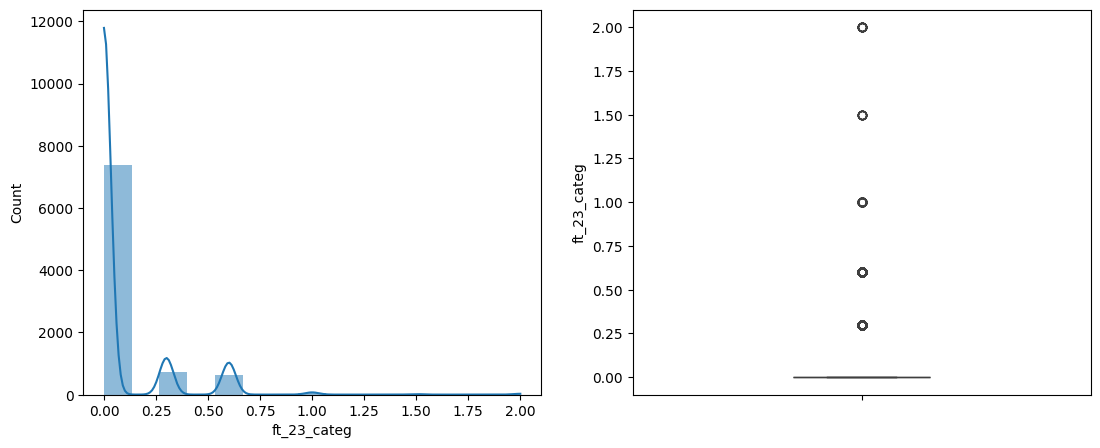

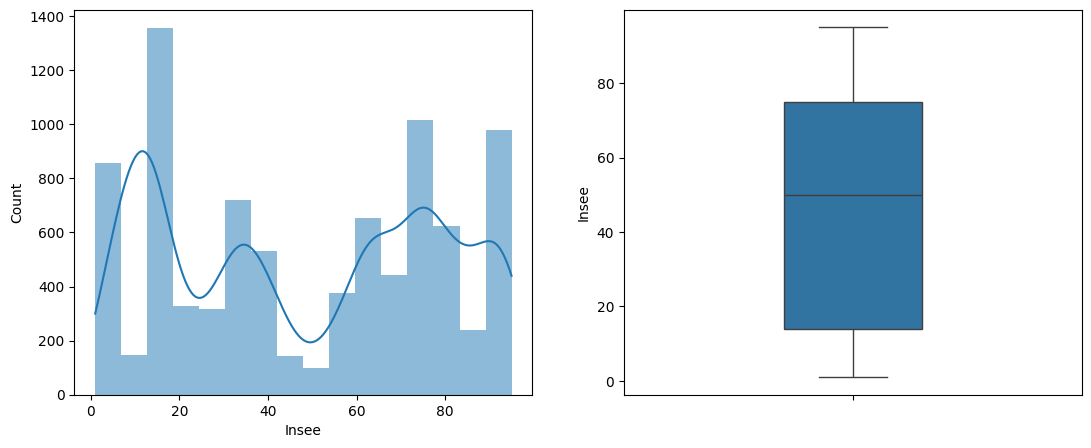

In [106]:
for col in clean_df.select_dtypes('object'):
    plt.figure(figsize=[13,5])

    plt.subplot(1,2,1)
    clean_df[col].value_counts().plot(kind="bar")
    
    plt.subplot(1,2,2)
    clean_df[col].value_counts().plot.pie()

    
for col in clean_df.select_dtypes(['float64', 'int64']):
    plt.figure(figsize=[13,5])

    plt.subplot(1,2,1)
    sns.histplot(clean_df[col], kde= True, edgecolor= None)

    plt.subplot(1,2,2)
    sns.boxplot(clean_df[col], width=0.3)

In [107]:
clean_df[clean_df['ft_10_categ'] == 'N']

,Identifiant,ft_2_categ,EXPO,ft_4_categ,ft_5_categ,ft_6_categ,ft_7_categ,ft_8_categ,ft_10_categ,ft_11_categ,...,ft_17_categ,ft_18_categ,ft_19_categ,superficief,ft_21_categ,ft_22_categ,ft_23_categ,ft_24_categ,Insee,target
121,17796,2015,0.983562,1,V,N,1,O,N,N,...,V,base,2,300.0,1,2005.0,0.3,3,74,0
774,11663,2015,1.000000,0,V,N,1,O,N,N,...,V,pi,1,350.0,1,2000.0,0.0,2,74,0
936,2673,2012,1.000000,0,V,N,1,O,N,N,...,V,pi,2,615.0,1,1968.0,0.0,3,74,0
966,17485,2014,1.000000,0,V,N,1,O,N,N,...,V,base,2,240.0,1,1850.0,0.0,3,10,0
1063,17486,2016,0.997268,0,V,N,1,O,N,N,...,V,base,2,240.0,1,1850.0,0.0,3,10,0
1106,7267,2013,1.000000,0,V,N,1,O,N,N,...,V,pi,2,470.0,2,1900.0,0.0,4,38,0
1794,17107,2016,1.000000,0,V,N,1,O,N,N,...,V,base,2,400.0,1,1700.0,0.6,3,10,1
2103,13902,2014,1.000000,1,V,N,2,O,N,N,...,V,pi,2,1052.0,2,1977.0,0.6,5,76,1
2327,20,2016,0.997268,0,V,N,1,O,N,N,...,V,pi,1,968.0,2,1915.0,0.0,3,38,0
3363,7266,2012,1.000000,0,V,N,1,O,N,N,...,V,pi,2,470.0,2,1900.0,0.0,4,38,0


On supprime la valeur 'N' pour cette variable car elle ne concerne qu'une faible partie des données.

In [108]:
clean_df = clean_df[clean_df['ft_10_categ'] != 'N']

In [109]:
print(clean_df['ft_6_categ'].value_counts())
print(clean_df['ft_8_categ'].value_counts())
print(clean_df['ft_10_categ'].value_counts())
print(clean_df['ft_15_categ'].value_counts())
print(clean_df['ft_16_categ'].value_counts())
print(clean_df['ft_17_categ'].value_counts())


ft_6_categ
V    4423
N    4395
Name: count, dtype: int64
ft_8_categ
V    4423
O    4395
Name: count, dtype: int64
ft_10_categ
V    4423
O    4395
Name: count, dtype: int64
ft_15_categ
V        4423
AUTRE    4395
Name: count, dtype: int64
ft_16_categ
V            4423
IDENTIQUE    4395
Name: count, dtype: int64
ft_17_categ
V    4395
N    4386
O      37
Name: count, dtype: int64


Premier constat, il y a seulement 37 'O' dans ft_17_categ ce qui est insignifiant. On peut les supprimer

In [110]:
clean_df = clean_df[clean_df['ft_17_categ'] != '0']

Second constat, on observe que la première valeur de chaque colonne est la même pour chacune de ses variables. De même pour la seconde valeur. On retrouve également une répartition 50/50 des valeurs

In [111]:
# Vérification des correspondances respectives
correspondance_N = clean_df[(clean_df['ft_6_categ'] == 'N') & (clean_df['ft_8_categ'] == 'O') & (clean_df['ft_10_categ'] == 'O') & (clean_df['ft_15_categ'] == 'AUTRE') & (clean_df['ft_16_categ'] == 'IDENTIQUE')]
correspondance_V = clean_df[(clean_df['ft_6_categ'] == 'V') & (clean_df['ft_8_categ'] == 'V') & (clean_df['ft_10_categ'] == 'V') & (clean_df['ft_15_categ'] == 'V') & (clean_df['ft_16_categ'] == 'V')]

# Affichage des résultats
print("Les valeurs 'V' correspondent dans les colonnes spécifiées :", correspondance_V.count())
print("Correspondance 'N' et 'O' :", correspondance_N.count())


Les valeurs 'V' correspondent dans les colonnes spécifiées : Identifiant    4423
ft_2_categ     4423
EXPO           4423
ft_4_categ     4423
ft_5_categ     4423
ft_6_categ     4423
ft_7_categ     4423
ft_8_categ     4423
ft_10_categ    4423
ft_11_categ    4423
ft_12_categ    4423
ft_13_categ    4423
ft_14_categ    4423
ft_15_categ    4423
ft_16_categ    4423
ft_17_categ    4423
ft_18_categ    4423
ft_19_categ    4423
superficief    4423
ft_21_categ    4423
ft_22_categ    4423
ft_23_categ    4423
ft_24_categ    4423
Insee          4423
target         4423
dtype: int64
Correspondance 'N' et 'O' : Identifiant    4395
ft_2_categ     4395
EXPO           4395
ft_4_categ     4395
ft_5_categ     4395
ft_6_categ     4395
ft_7_categ     4395
ft_8_categ     4395
ft_10_categ    4395
ft_11_categ    4395
ft_12_categ    4395
ft_13_categ    4395
ft_14_categ    4395
ft_15_categ    4395
ft_16_categ    4395
ft_17_categ    4395
ft_18_categ    4395
ft_19_categ    4395
superficief    4395
ft_21_categ    439

In [112]:
clean_df.drop(columns=['ft_8_categ'], inplace=True)
clean_df.drop(columns=['ft_10_categ'], inplace=True)
clean_df.drop(columns=['ft_15_categ'], inplace=True)
clean_df.drop(columns=['ft_16_categ'], inplace=True)

In [113]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8818 entries, 0 to 10228
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Identifiant  8818 non-null   int64  
 1   ft_2_categ   8818 non-null   int64  
 2   EXPO         8818 non-null   float64
 3   ft_4_categ   8818 non-null   object 
 4   ft_5_categ   8818 non-null   object 
 5   ft_6_categ   8818 non-null   object 
 6   ft_7_categ   8818 non-null   object 
 7   ft_11_categ  8818 non-null   object 
 8   ft_12_categ  8818 non-null   object 
 9   ft_13_categ  8818 non-null   object 
 10  ft_14_categ  8818 non-null   object 
 11  ft_17_categ  8818 non-null   object 
 12  ft_18_categ  8818 non-null   object 
 13  ft_19_categ  8818 non-null   object 
 14  superficief  8818 non-null   float64
 15  ft_21_categ  8818 non-null   int64  
 16  ft_22_categ  8818 non-null   float64
 17  ft_23_categ  8818 non-null   float64
 18  ft_24_categ  8818 non-null   object 
 19  Insee     

In [114]:
for variable in clean_df:
    print(clean_df[variable].value_counts())

Identifiant
18702    1
6538     1
5267     1
18593    1
2748     1
        ..
13558    1
3748     1
442      1
12625    1
8817     1
Name: count, Length: 8818, dtype: int64
ft_2_categ
2012    2292
2013    2208
2014    1680
2015    1347
2016    1291
Name: count, dtype: int64
EXPO
1.000000    6725
0.997268     681
0.000000      85
0.747945      73
0.495890      57
            ... 
0.024658       1
0.117808       1
0.303279       1
0.467213       1
0.290411       1
Name: count, Length: 424, dtype: int64
ft_4_categ
0    6448
1    2370
Name: count, dtype: int64
ft_5_categ
V    6375
N    2443
Name: count, dtype: int64
ft_6_categ
V    4423
N    4395
Name: count, dtype: int64
ft_7_categ
V    4459
1    3050
2     959
3     350
Name: count, dtype: int64
ft_11_categ
V    4423
N    4395
Name: count, dtype: int64
ft_12_categ
V    4423
N    3741
O     654
Name: count, dtype: int64
ft_13_categ
V    4423
N    2559
O    1836
Name: count, dtype: int64
ft_14_categ
V    4423
N    3988
O     407
Name: coun

On nettoie le jeux de donnée en normalisant les valeurs:

In [115]:
#colonnes_a_remplacer_V = clean_df.columns.difference(['ft_18_categ'])
#clean_df[colonnes_a_remplacer_V] = clean_df[colonnes_a_remplacer_V].replace('V', 0)
#clean_df[colonnes_a_remplacer_V] = clean_df[colonnes_a_remplacer_V].replace('N', 1)
#clean_df[colonnes_a_remplacer_V] = clean_df[colonnes_a_remplacer_V].replace('O', 2)

clean_df['ft_24_categ'] = clean_df['ft_24_categ'].str.replace('.', '0')

In [116]:
for variable in clean_df:
    print(clean_df[variable].value_counts())

Identifiant
18702    1
6538     1
5267     1
18593    1
2748     1
        ..
13558    1
3748     1
442      1
12625    1
8817     1
Name: count, Length: 8818, dtype: int64
ft_2_categ
2012    2292
2013    2208
2014    1680
2015    1347
2016    1291
Name: count, dtype: int64
EXPO
1.000000    6725
0.997268     681
0.000000      85
0.747945      73
0.495890      57
            ... 
0.024658       1
0.117808       1
0.303279       1
0.467213       1
0.290411       1
Name: count, Length: 424, dtype: int64
ft_4_categ
0    6448
1    2370
Name: count, dtype: int64
ft_5_categ
V    6375
N    2443
Name: count, dtype: int64
ft_6_categ
V    4423
N    4395
Name: count, dtype: int64
ft_7_categ
V    4459
1    3050
2     959
3     350
Name: count, dtype: int64
ft_11_categ
V    4423
N    4395
Name: count, dtype: int64
ft_12_categ
V    4423
N    3741
O     654
Name: count, dtype: int64
ft_13_categ
V    4423
N    2559
O    1836
Name: count, dtype: int64
ft_14_categ
V    4423
N    3988
O     407
Name: coun

Au vu des écarts de valeur importants pour les variables superficief et ft_22_catef, on choisit d'appliquer une standardisation.

In [117]:
clean_df['superficief'] = (clean_df['superficief'] - clean_df['superficief'].mean()) / clean_df['superficief'].std()
clean_df['ft_22_categ'] = (clean_df['ft_22_categ'] - clean_df['ft_22_categ'].mean()) / clean_df['ft_22_categ'].std()


In [118]:
print(clean_df['ft_24_categ'].value_counts())

ft_24_categ
   0    4423
   4    1125
   3    1053
   5     784
   2     427
   6     374
   7     265
   8     141
   1      90
>=10      77
   9      59
Name: count, dtype: int64


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_17804\477390759.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[13,5])


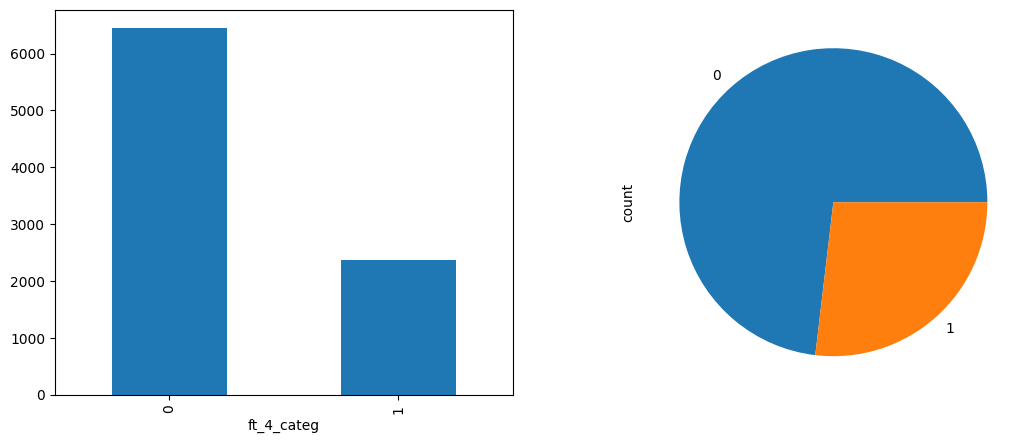

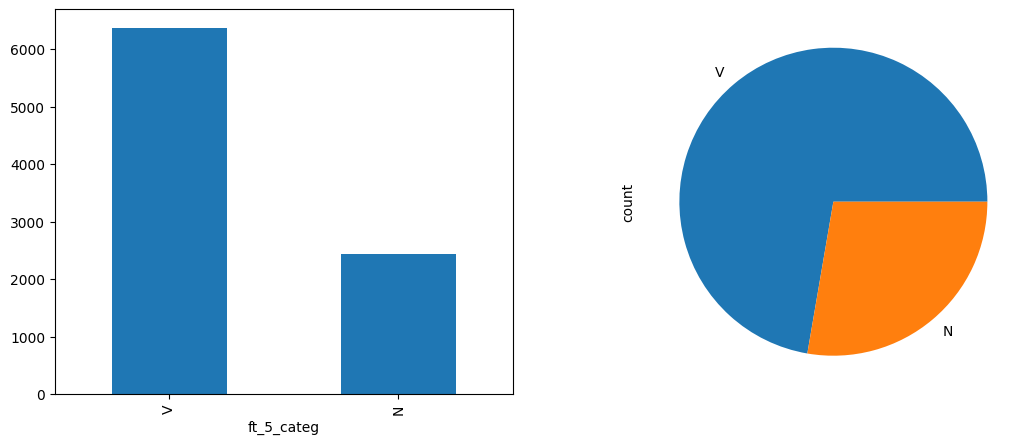

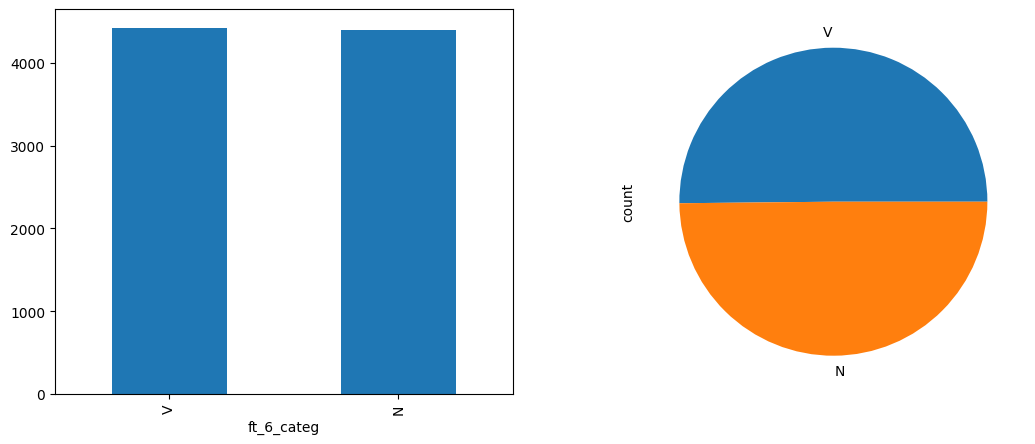

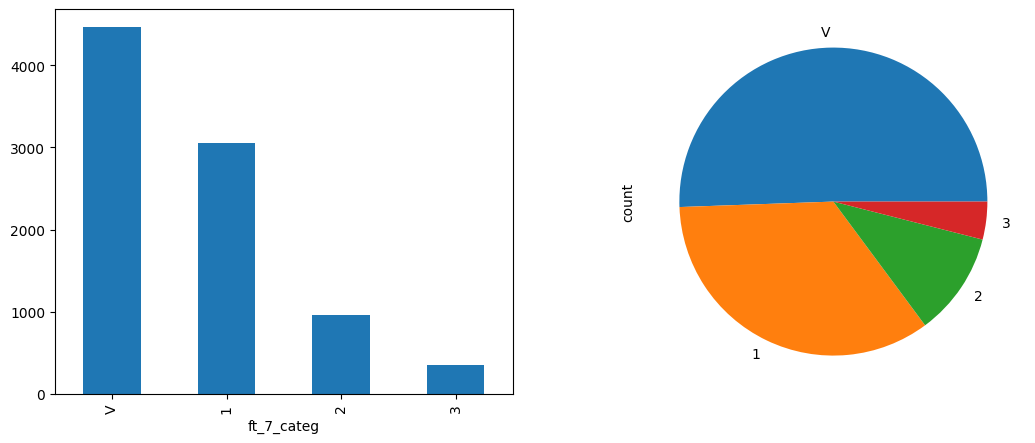

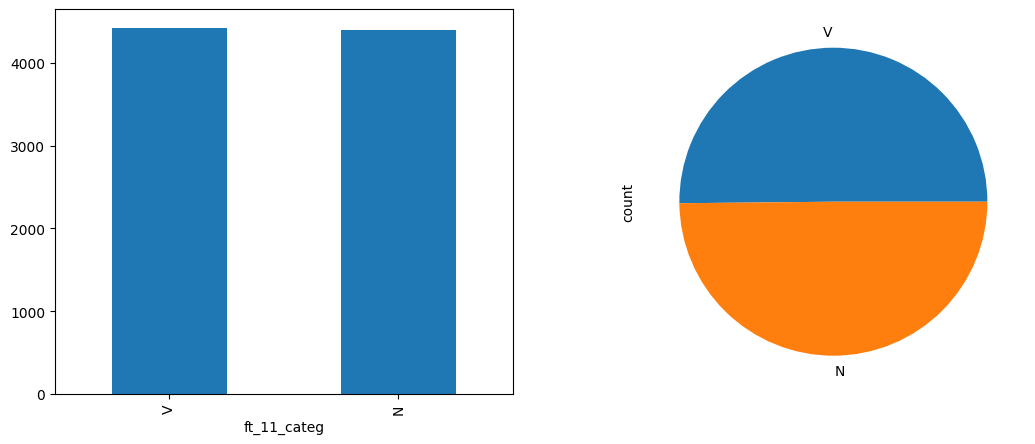

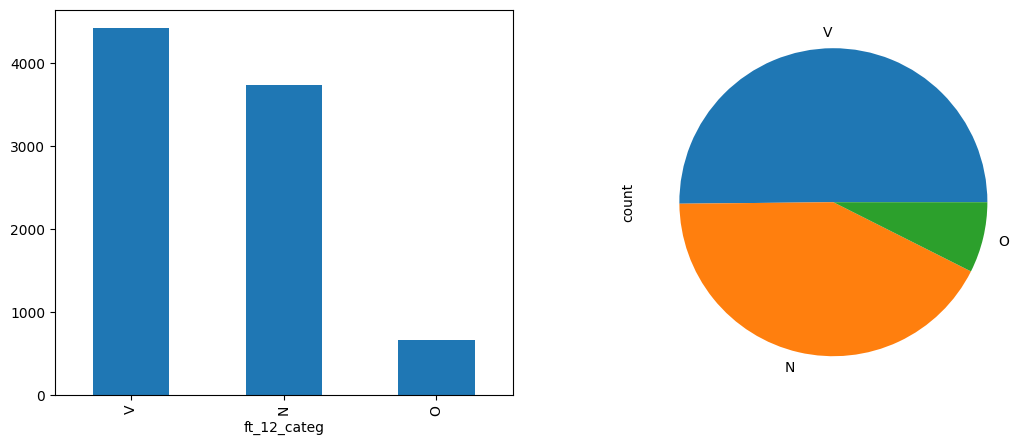

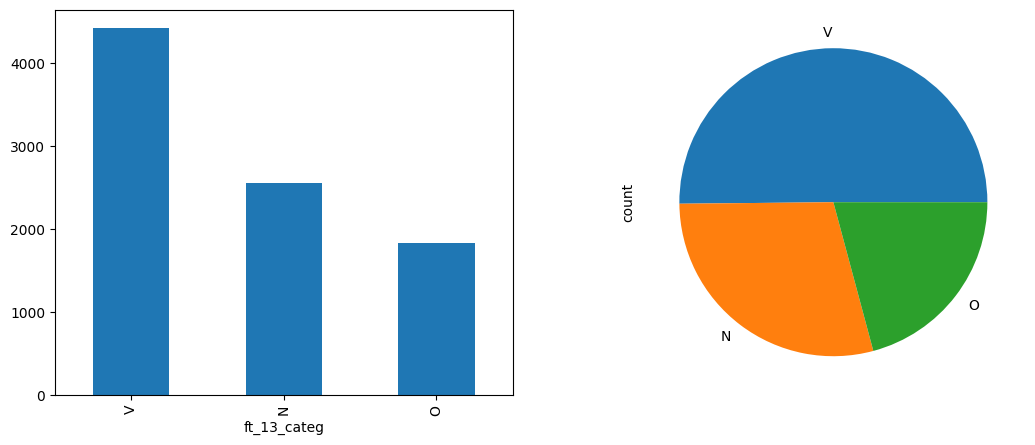

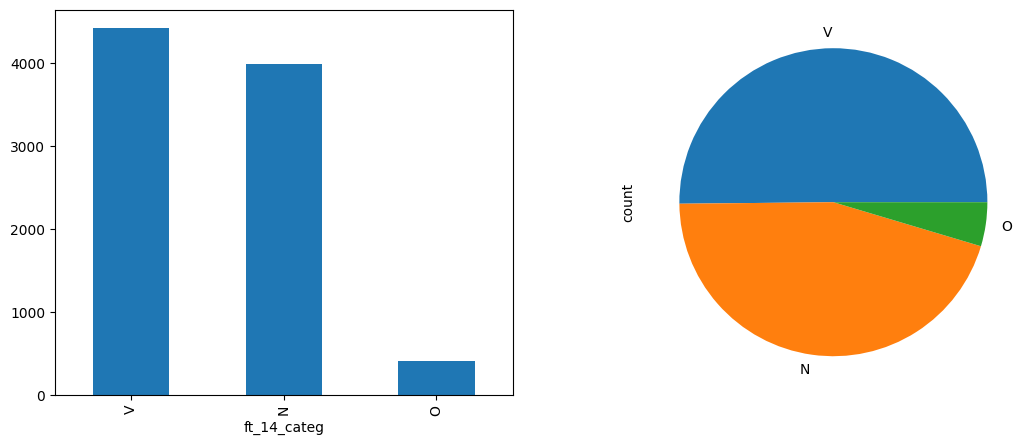

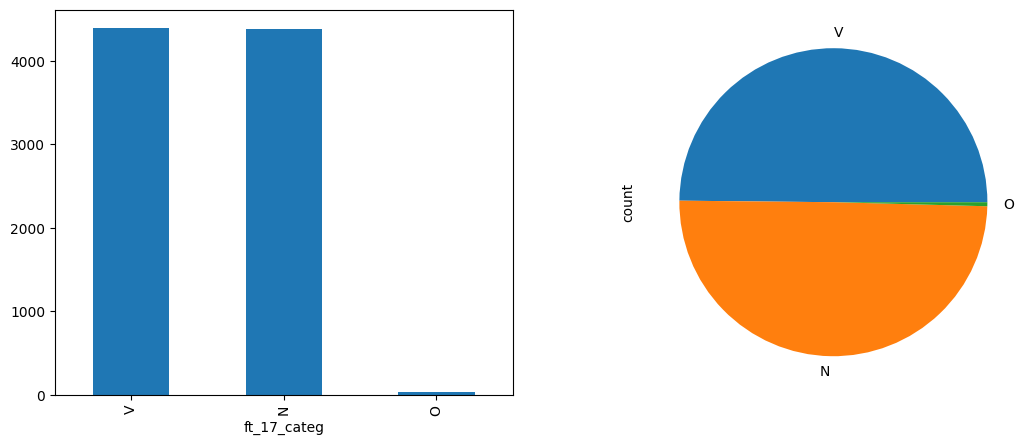

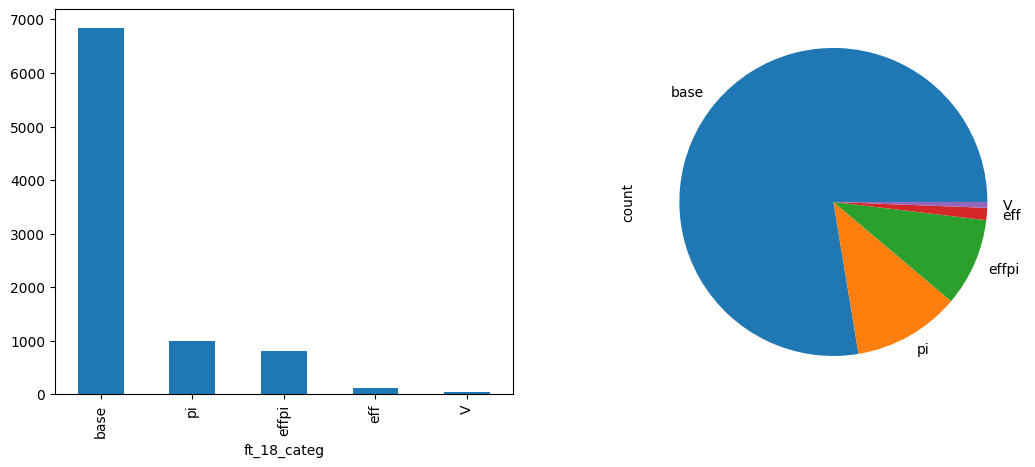

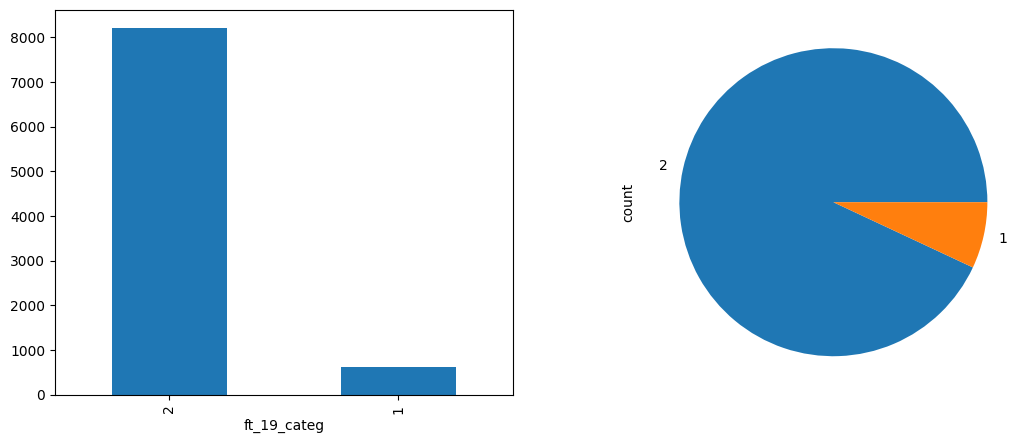

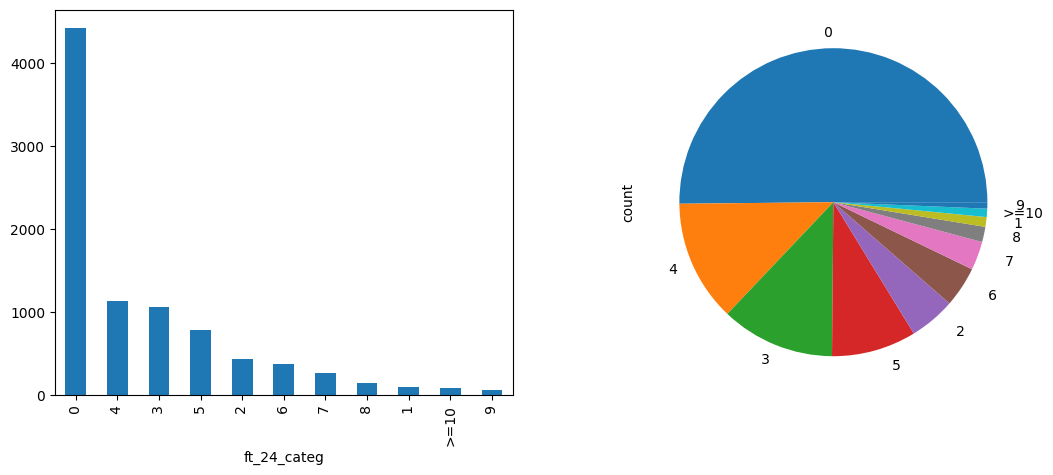

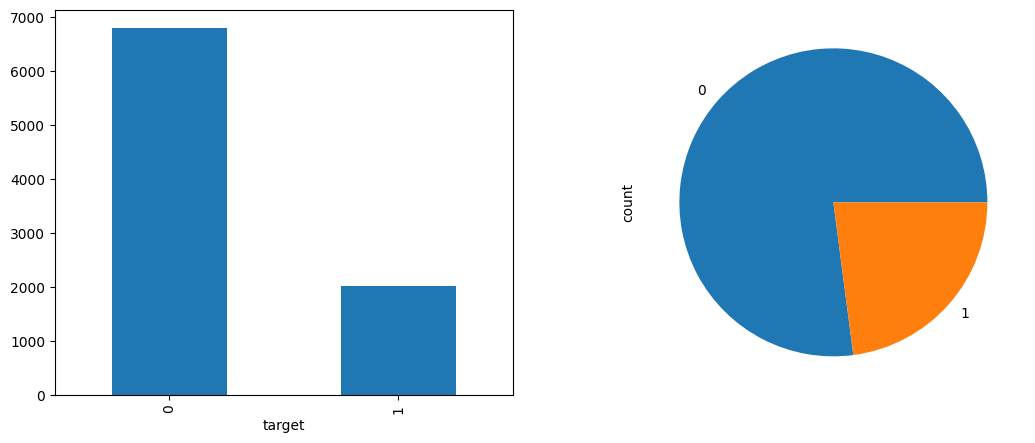

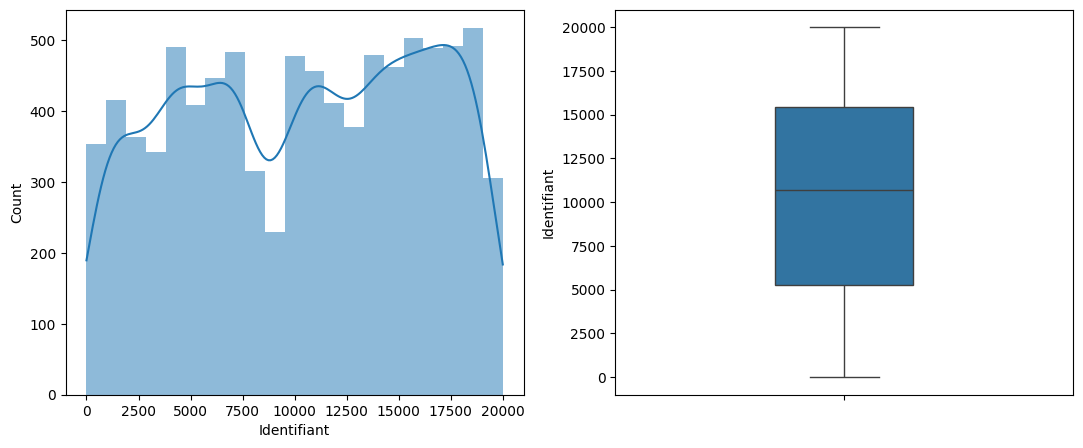

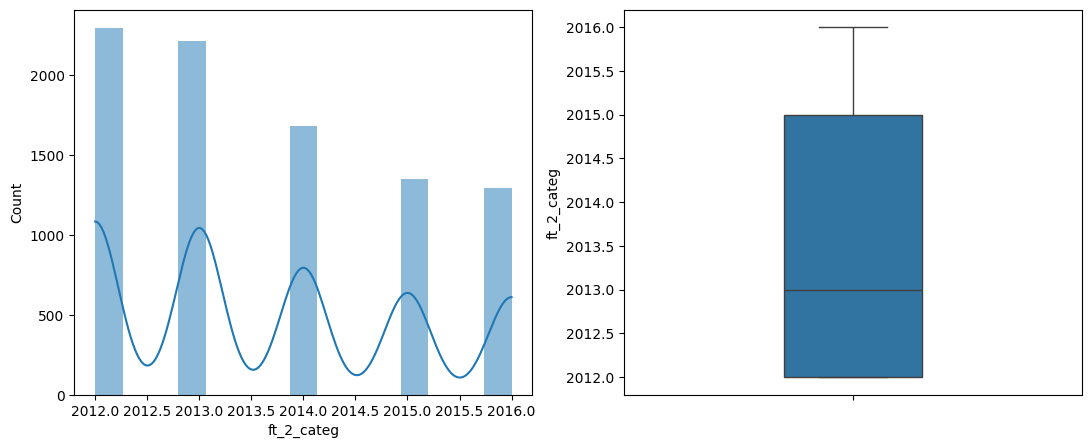

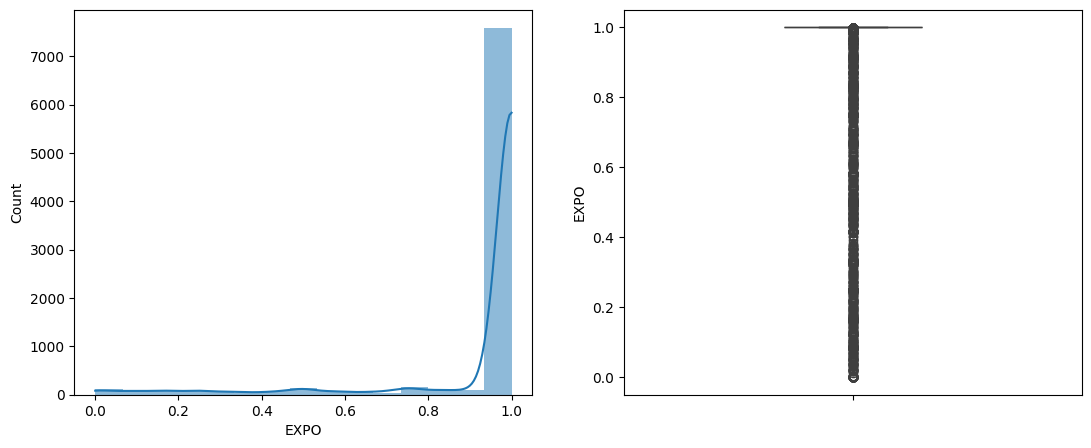

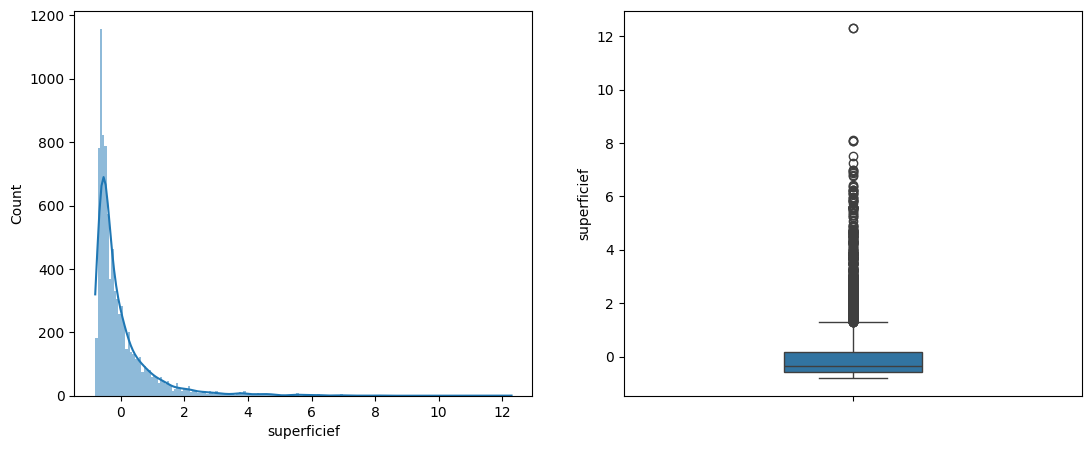

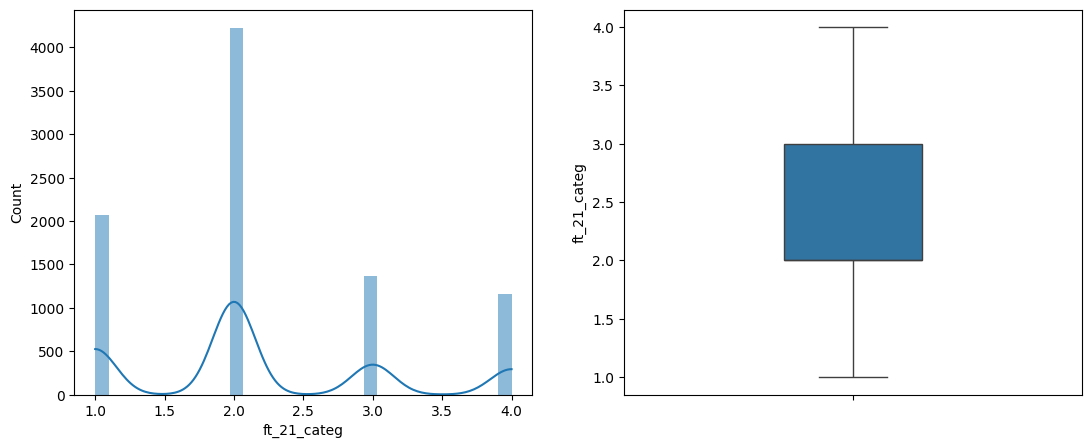

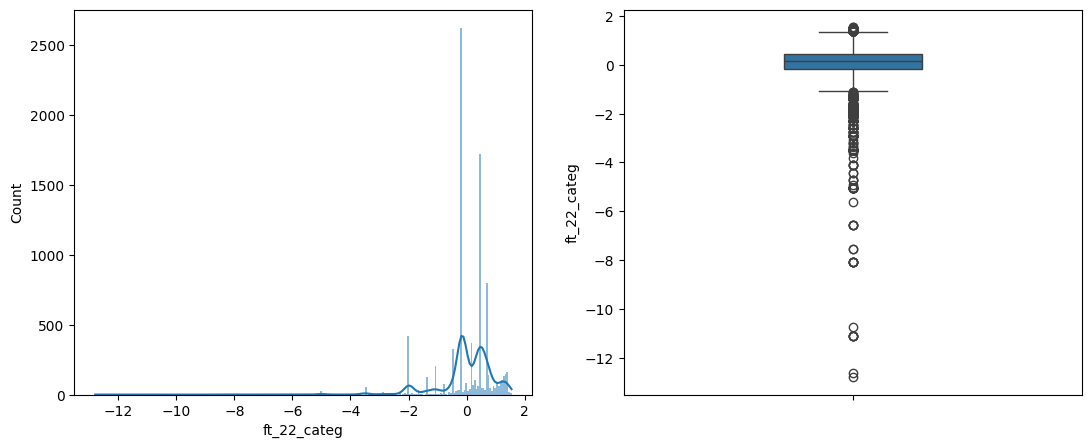

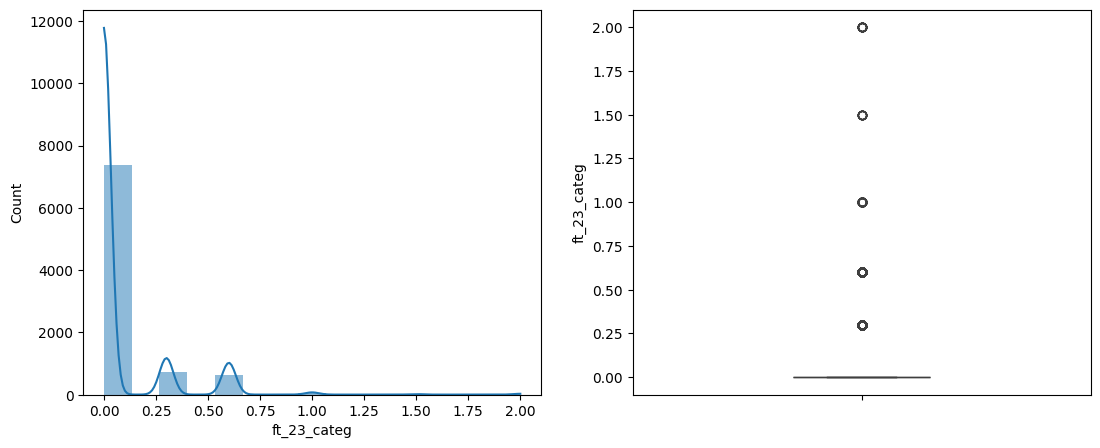

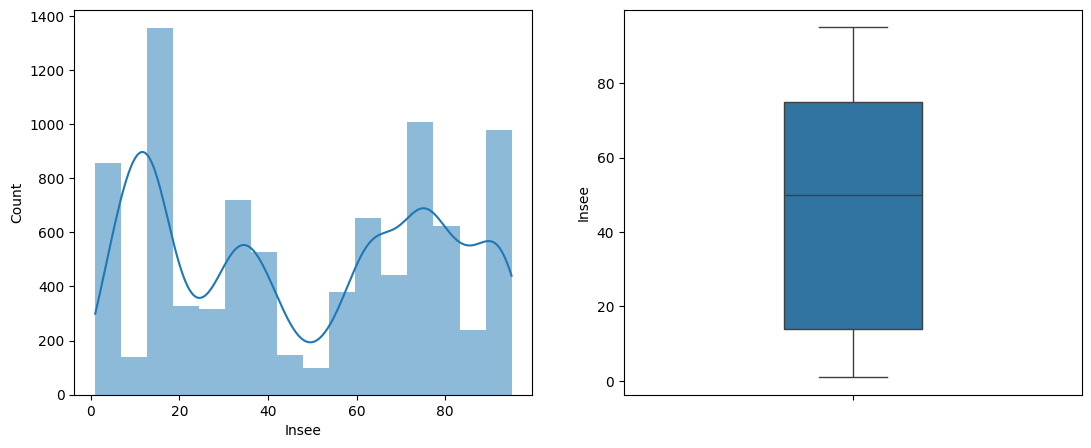

In [119]:
for col in clean_df.select_dtypes('object'):
    plt.figure(figsize=[13,5])

    plt.subplot(1,2,1)
    clean_df[col].value_counts().plot(kind="bar")
    
    plt.subplot(1,2,2)
    clean_df[col].value_counts().plot.pie()

    
for col in clean_df.select_dtypes(['float64', 'int64']):
    plt.figure(figsize=[13,5])

    plt.subplot(1,2,1)
    sns.histplot(clean_df[col], kde= True, edgecolor= None)

    plt.subplot(1,2,2)
    sns.boxplot(clean_df[col], width=0.3)

Nous regardons maintenant les differences entre les variables selon la valeur de target.

In [120]:
positive_df = clean_df[clean_df['target'] == 1]
negative_df = clean_df[clean_df['target'] == 0]

In [121]:
positive_df.value_counts()

Identifiant  ft_2_categ  EXPO      ft_4_categ  ft_5_categ  ft_6_categ  ft_7_categ  ft_11_categ  ft_12_categ  ft_13_categ  ft_14_categ  ft_17_categ  ft_18_categ  ft_19_categ  superficief  ft_21_categ  ft_22_categ  ft_23_categ  ft_24_categ  Insee  target
13           2015        1.000000  0           V           N           1           N            N            O            N            V            pi           2            -0.597116    2            -0.768617    0.6          4            13     1         1
14616        2013        1.000000  1           N           V           V           V            V            V            V            N            base         2            -0.315787    4            -0.160092    0.0          0            75     1         1
14734        2012        1.000000  1           N           V           V           V            V            V            V            N            base         2            -0.499077    4            -0.160092    0.0          0    

In [122]:
negative_df.value_counts()

Identifiant  ft_2_categ  EXPO      ft_4_categ  ft_5_categ  ft_6_categ  ft_7_categ  ft_11_categ  ft_12_categ  ft_13_categ  ft_14_categ  ft_17_categ  ft_18_categ  ft_19_categ  superficief  ft_21_categ  ft_22_categ  ft_23_categ  ft_24_categ  Insee  target
0            2013        0.350685  0           V           V           V           V            V            V            V            N            base         2            -0.646562    2             0.448434    0.0          0            26     0         1
13764        2015        1.000000  0           N           V           V           V            V            V            V            N            base         2            -0.383988    2            -0.160092    0.0          0            13     0         1
13759        2016        1.000000  1           N           V           V           V            V            V            V            N            base         2            -0.383988    3            -0.160092    0.0          0    

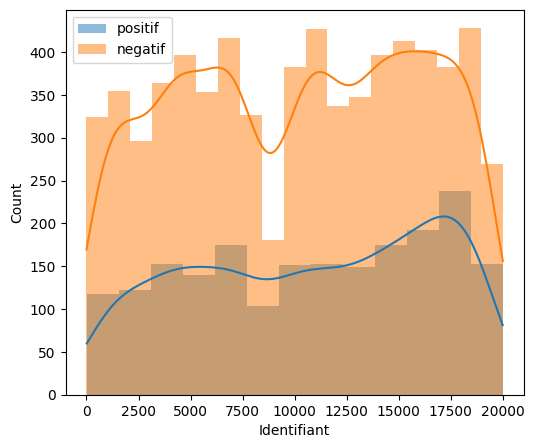

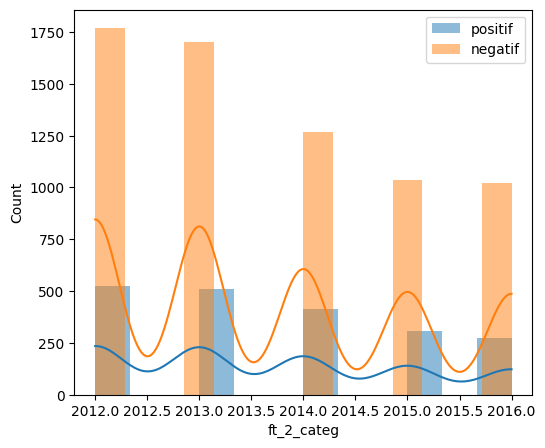

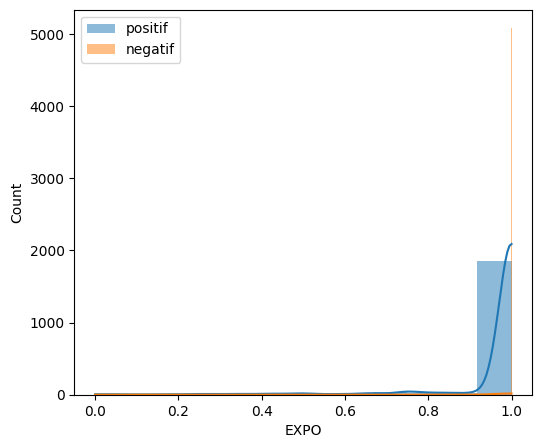

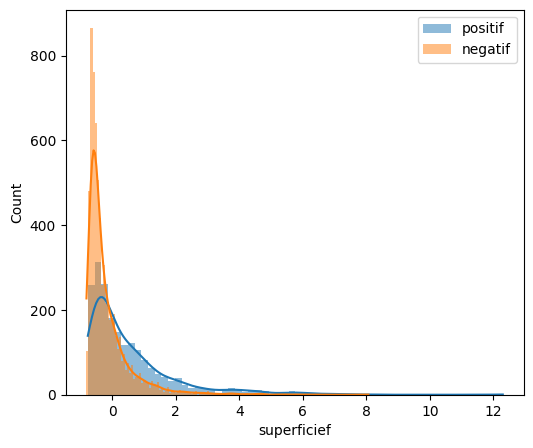

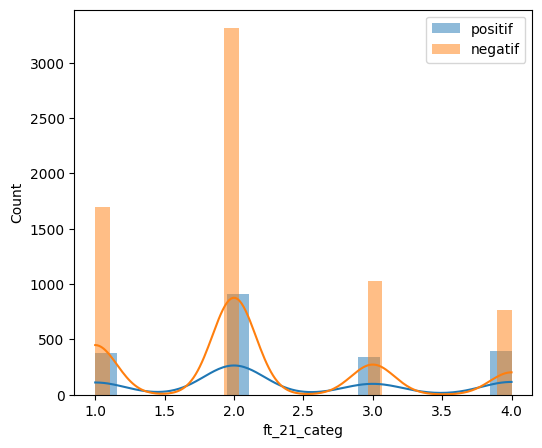

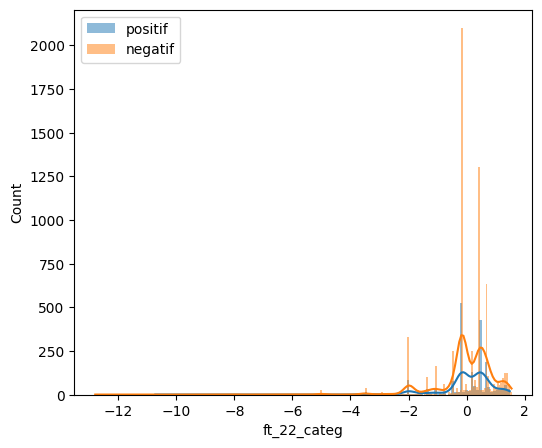

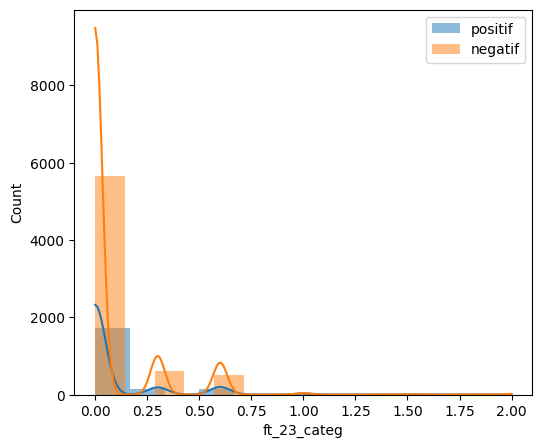

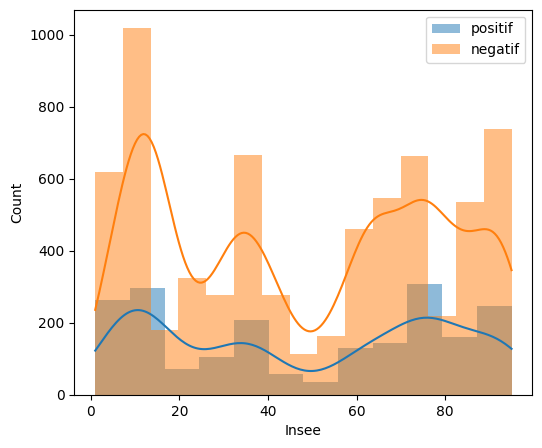

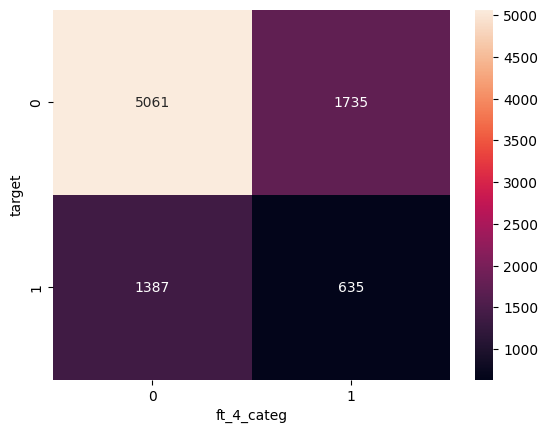

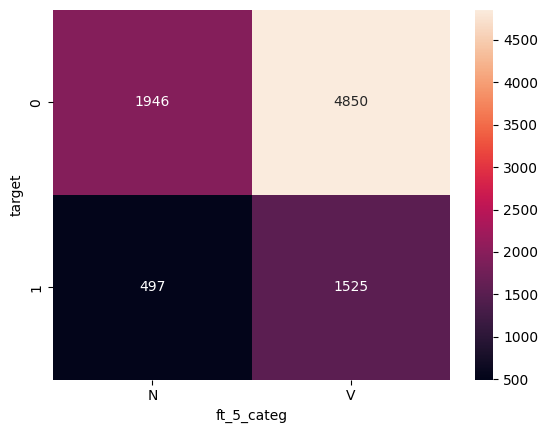

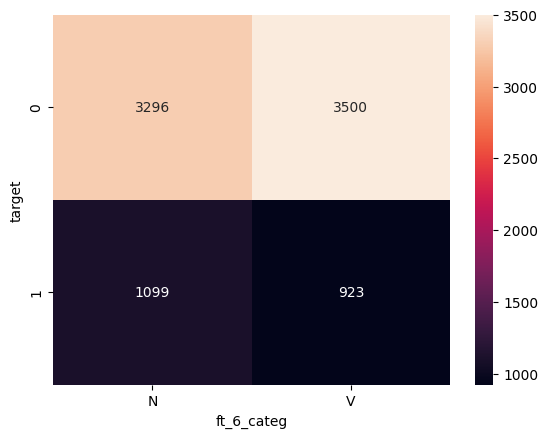

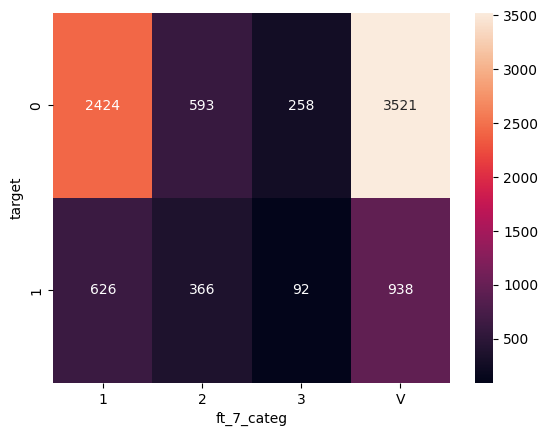

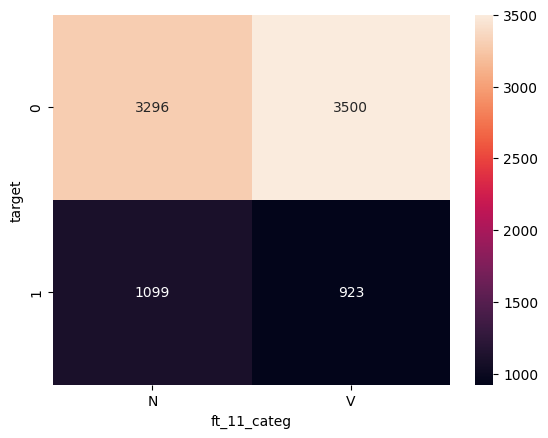

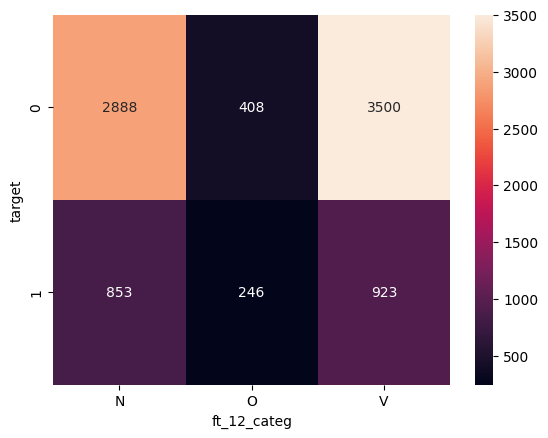

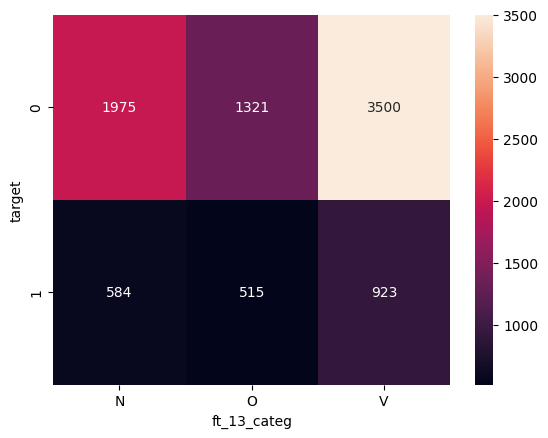

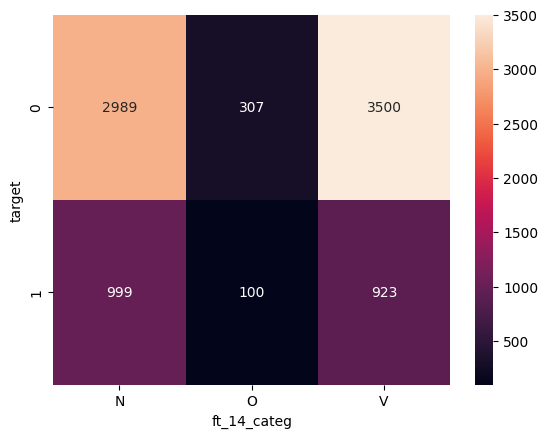

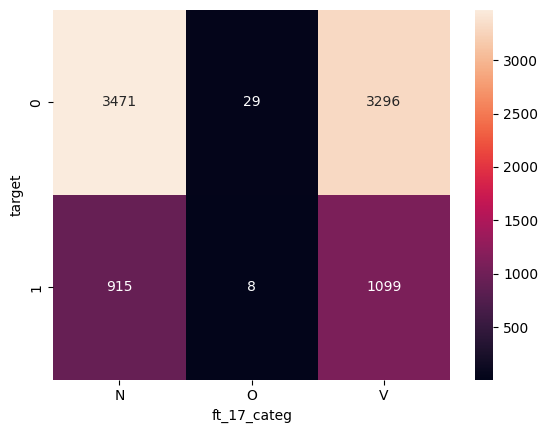

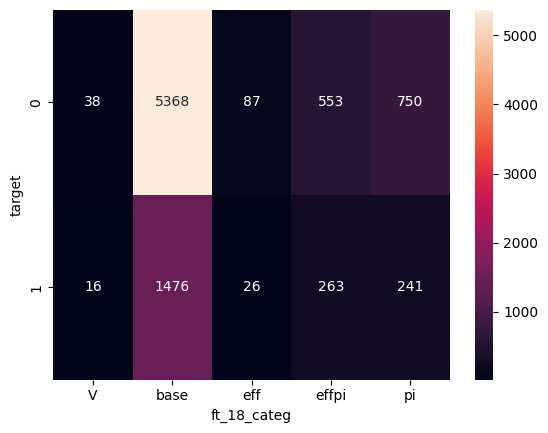

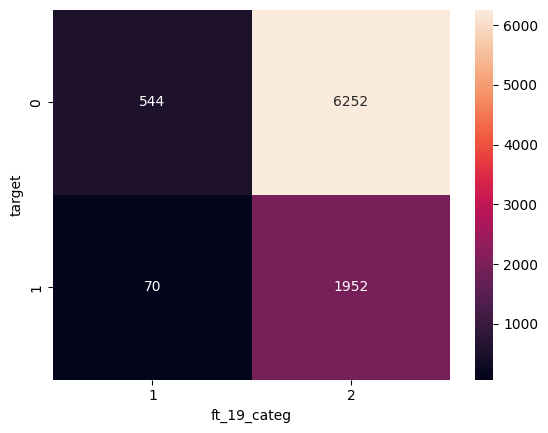

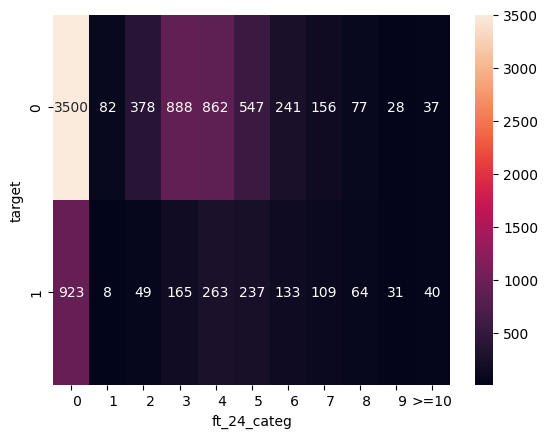

In [123]:
for col in positive_df.select_dtypes(['float64', 'int64']):
    plt.figure(figsize=[13,5])

    plt.subplot(1,2,1)
    sns.histplot(positive_df[col], kde=True, label = 'positif', edgecolor = None)
    sns.histplot(negative_df[col], kde=True, label = 'negatif', edgecolor = None)

    plt.legend()
    plt.show()

for col in clean_df.drop('target', axis = 1).select_dtypes('object'):
    plt.figure()
    sns.heatmap(pd.crosstab(clean_df['target'], clean_df[col]), annot=True, fmt='d')

Le jeu de données est maintenant propre, nous allons travailler les modèles

In [124]:
trainsset, testset = train_test_split(clean_df, test_size=0.2, random_state=0)

In [125]:
trainsset['target'].value_counts()

target
0    5426
1    1628
Name: count, dtype: int64

In [126]:
testset['target'].value_counts()

target
0    1370
1     394
Name: count, dtype: int64

In [127]:
def preprocessing(df):
    
    #encodage
    df = pd.get_dummies(df, columns=list(df.drop(['target','Insee'],axis=1).select_dtypes('object').columns), dtype=int)
    
    df['target'] = df['target'].astype('int')
    print(df.info())
    #Selection des variables
    df.drop(columns=['Identifiant','ft_19_categ_2','ft_13_categ_V','ft_12_categ_N','ft_4_categ_1','ft_5_categ_V','ft_6_categ_V','ft_7_categ_V','ft_11_categ_V','ft_17_categ_N','ft_17_categ_O','ft_24_categ_   0', 'ft_6_categ_N','ft_11_categ_N','ft_12_categ_V','ft_14_categ_N','ft_14_categ_V','ft_23_categ','ft_7_categ_3','ft_12_categ_O','ft_12_categ_O','ft_18_categ_V','ft_14_categ_O','ft_18_categ_V','ft_18_categ_eff','ft_18_categ_effpi','ft_19_categ_1','ft_24_categ_   1','ft_24_categ_   2','ft_24_categ_   5','ft_24_categ_   6','ft_24_categ_   7','ft_24_categ_   8','ft_24_categ_   9','ft_24_categ_>=10'], inplace=True)
    
    #division variables explicatives et variable cible    
    x = df.drop('target', axis=1)
    y = df['target']
    
    #x = StandardScaler().fit_transform(x)
    return x, y

In [128]:
x_train, y_train = preprocessing(trainsset)
x_test, y_test = preprocessing(testset)


<class 'pandas.core.frame.DataFrame'>
Index: 7054 entries, 6757 to 3164
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Identifiant        7054 non-null   int64  
 1   ft_2_categ         7054 non-null   int64  
 2   EXPO               7054 non-null   float64
 3   superficief        7054 non-null   float64
 4   ft_21_categ        7054 non-null   int64  
 5   ft_22_categ        7054 non-null   float64
 6   ft_23_categ        7054 non-null   float64
 7   Insee              7054 non-null   int64  
 8   target             7054 non-null   int32  
 9   ft_4_categ_0       7054 non-null   int32  
 10  ft_4_categ_1       7054 non-null   int32  
 11  ft_5_categ_N       7054 non-null   int32  
 12  ft_5_categ_V       7054 non-null   int32  
 13  ft_6_categ_N       7054 non-null   int32  
 14  ft_6_categ_V       7054 non-null   int32  
 15  ft_7_categ_1       7054 non-null   int32  
 16  ft_7_categ_2       7054 no

In [129]:
model = SVC(random_state=0)
model.fit(x_train, y_train)

SVC(random_state=0)

In [130]:
y_pred = model.predict(x_test)
len(y_pred)

1764

In [131]:
len(y_test)

1764

Premier model

In [132]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1370    0]
 [ 394    0]]


In [133]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      1370
           1       0.00      0.00      0.00       394

    accuracy                           0.78      1764
   macro avg       0.39      0.50      0.44      1764
weighted avg       0.60      0.78      0.68      1764



c:\Users\Utilisateur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Utilisateur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Utilisateur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [134]:
N, train_score, val_score = learning_curve(model, x_train, y_train, cv=4, scoring = 'f1', train_sizes=np.linspace(0.1,1,10))

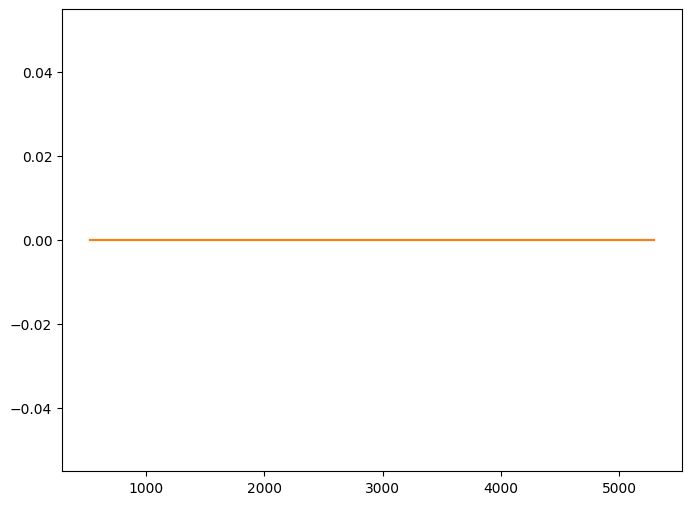

In [135]:
plt.figure(figsize=(8,6))
plt.plot(N, train_score.mean(axis= 1), label= "train_score")
plt.plot(N, val_score.mean(axis= 1), label= "train_score")

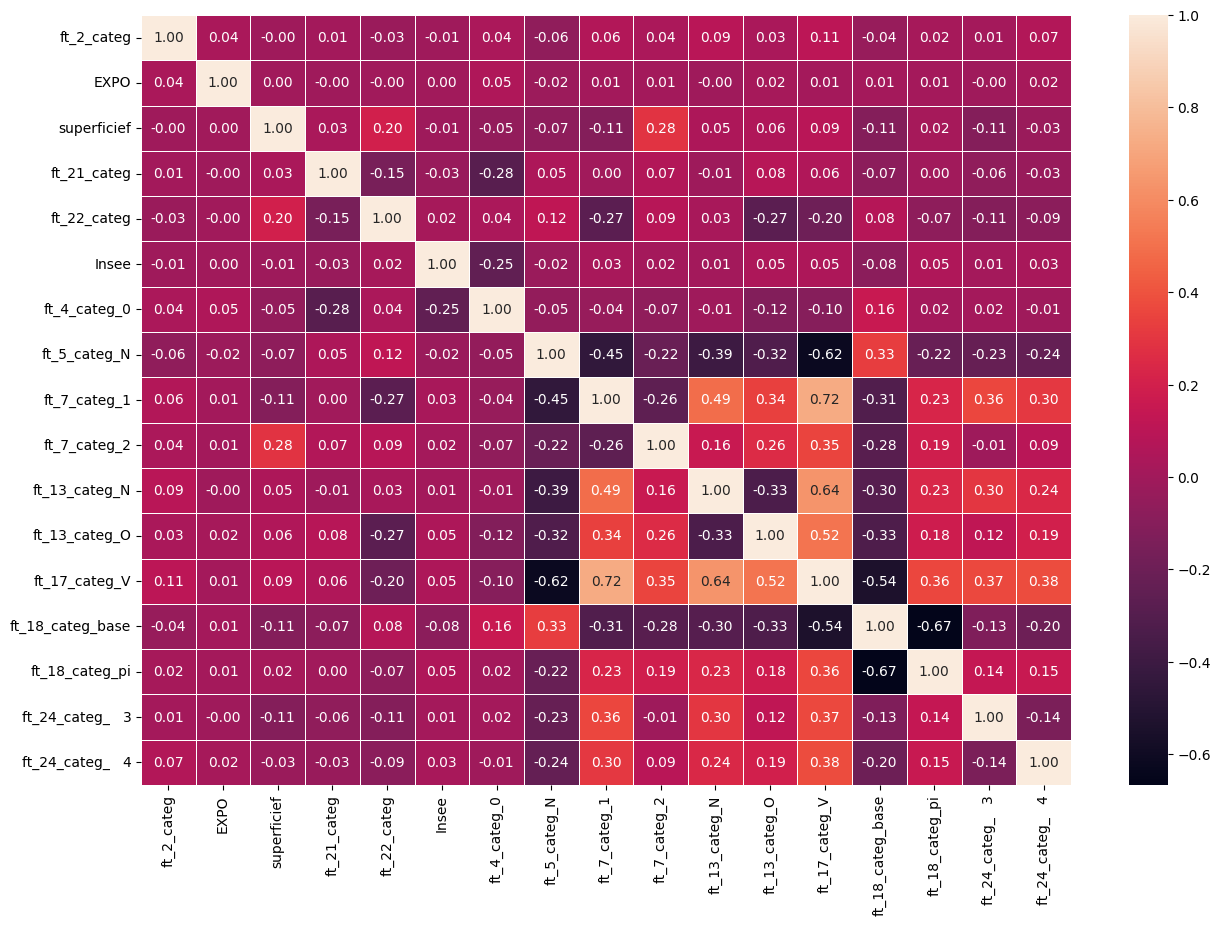

In [136]:
corr_mat = x_train.corr()
fig, ax = plt.subplots(figsize=[15,10])
ax = sns.heatmap(corr_mat, annot=True, linewidths=0.5, fmt="0.2f")

In [137]:
x_train.var(axis=0)

ft_2_categ            1.924328
EXPO                  0.044545
superficief           1.029398
ft_21_categ           0.880262
ft_22_categ           1.014672
Insee               906.866222
ft_4_categ_0          0.196960
ft_5_categ_N          0.199413
ft_7_categ_1          0.226678
ft_7_categ_2          0.099795
ft_13_categ_N         0.206484
ft_13_categ_O         0.167939
ft_17_categ_V         0.250012
ft_18_categ_base      0.175708
ft_18_categ_pi        0.102312
ft_24_categ_   3      0.106317
ft_24_categ_   4      0.111852
dtype: float64